In [83]:
# Library Imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import my_functions as mf
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq
from scipy.special import voigt_profile
from scipy.signal import convolve
import re
import importlib
importlib.reload(mf)
from collections import defaultdict

In [88]:
data_path = "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/"
figure_save_path="/Users/fergusayton/Documents/My Library/fayt3249/2024/Honours Thesis/Thesis Figures and Diagrams/Figures/MyResults"
data_file = "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-02-00_freq_195.11847_rng_36.6852_gain_30_fld_0.09069666666666668.csv"


## Functions ## 

In [89]:
def read_B_field(file_name):
    match = re.search(r'fld_([0-9.]+)', file_name)
    if match: 
        
        b_field = float(match.group(1).strip("."))
        return b_field
    else: 
        print("Error: field value not found in filename.")



def normalise_traces(traces, floors = None, flip = False):
    '''
    Normalisation function for traces. Normalised between a provided floor for *each* trace
    (or zero) and the maximum of each array OR between zero and the maximum, if no floors provided.

    If flip is true, then subtracts 1 at the end and flips, so it's an upwards peak (for peak fitting convenience).

    Inputs:
        traces: enumerable of individual np.arrays. Typically a tuple. 
        floors = None: enumerable of detector floors/blanks the gain setting used to take data. This value will be subtracted before normalisation. 
        flip = False: if true, make the background 0 and flip the peaks so that they go upwards (rather than down from 1). 
    
    Returns:
        cal_traces: tuple of individual np.arrays.
    '''
    
    # If no floors provided, make them all zero
    if not floors:
        floors = np.zeros(len(traces))
    # Do the thing
    if flip: # if flip true then flip it
        cal_traces = tuple( 
            -1*((trace - floors[i]) / (np.max(trace) - floors[i]) - 1) for i, trace in enumerate(traces)
        )
    else: # otherwise don't flip it
        cal_traces = tuple( 
            (trace - floors[i]) / (np.max(trace) - floors[i]) for i, trace in enumerate(traces)
        )
    
    return cal_traces

    

## Single Spectrum ## 

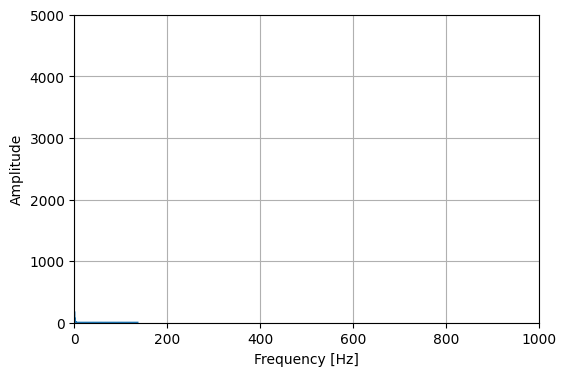

<Figure size 640x480 with 0 Axes>

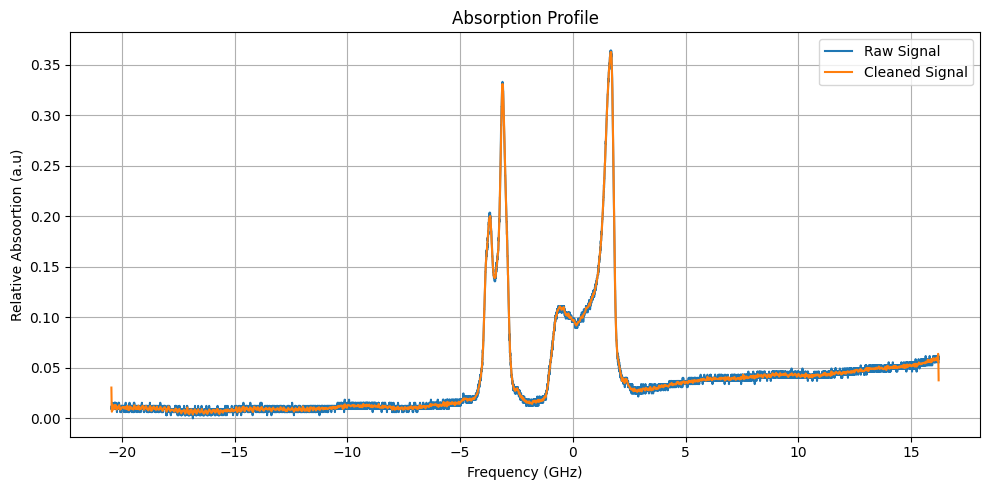

In [90]:

# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Normalise and Flip absorotion 
# signal = -voltage
# signal = mf.normalise_0_1(signal)


voltage_traces = (voltage,)  # tuple of a single 1D array
floors = (-0.03080024083683403,)

# Apply normalization (flip=True if you want dips → peaks)
normalized_traces = mf.normalise_traces(voltage_traces, floors=floors, flip=True)
signal =normalized_traces[0]

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9
## Low Pass Band Filter ## 20 Hz. 
cleaned = mf.low_pass_band_filter_fft(20,freq_axis_GHz,signal,plot_check=True)

# Plot absorption profile
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(freq_axis_GHz, signal, label='Raw Signal')
ax.plot(freq_axis_GHz, cleaned, label='Cleaned Signal')
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Relative Absoortion (a.u)")
ax.set_title("Absorption Profile")
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()



## 2D Colour Map ## 

In [51]:
data_files =  sorted(glob.glob(data_path +"*"))

voltages = [] 
fields = [] 

for file in data_files: 
    # Step 1: read CSV
    data = pd.read_csv(file, header=None)
    # Extract time, signal, and frequency
    time_axis = data.iloc[0].values.astype(float)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)

    #voltage = mf.low_pass_band_filter_fft(20,freq_axis_GHz,voltage,plot_check=False)

    # Convert frequency from Hz to GHz for cleaner axis
    freq_axis_GHz = freq_axis / 1e9

    B_field = read_B_field(file_name=file)
    fields.append(B_field)
    voltages.append(voltage)

fields = np.array(fields)
voltages = np.array(voltages)

# Sort by magnetic fieldusing arg sort
sort_idx = np.argsort(fields)
fields = fields[sort_idx]
voltages = voltages[sort_idx]


In [85]:
## Shift Frequency and  Normalise Volatage ## 
freq_shift = -0.675555 # GHz
freq_axis_GHz= freq_axis_GHz-freq_shift

signals = -voltages
signals = mf.normalise_0_1(signals)

    # Convert voltages list to tuple of 1D arrays
voltage_traces = tuple(voltages)

# Optional: detector floors (if known), otherwise will default to 0
# Example: floors = np.array([np.min(v) for v in voltage_traces])
floors =tuple(-0.0035351922089636857*np.ones(len(voltage_traces))) # or: floors = np.array([0.0]*len(voltage_traces))

# Apply normalization (flip=True if you want dips → peaks)
normalized_traces = normalise_traces(voltage_traces, floors=floors, flip=True)
signals = np.array(normalized_traces)

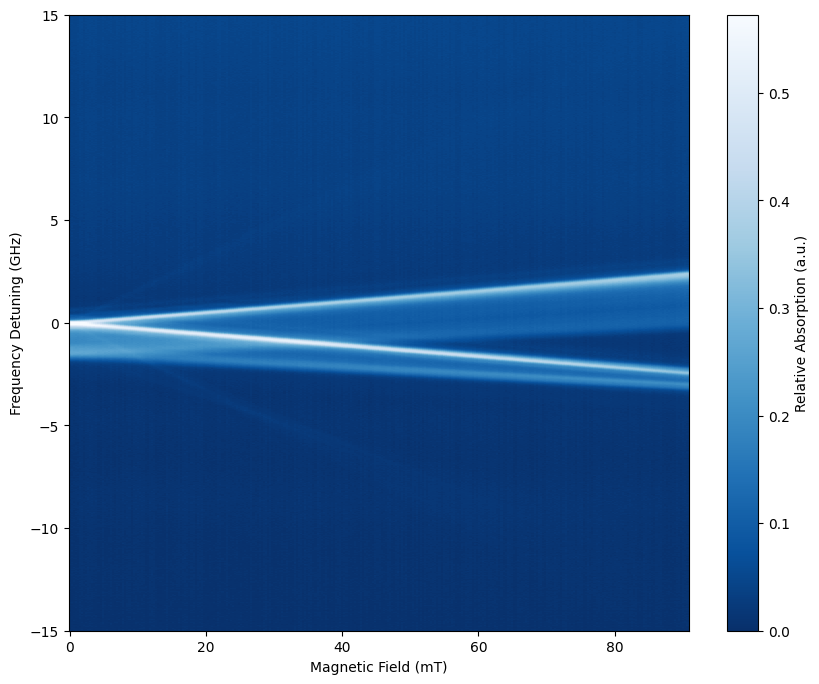

In [86]:
fig, ax = plt.subplots(figsize=(10,8))
#c= ax.pcolormesh(freq_axis_GHz, fields * 1000, voltages, shading='auto', cmap='Blues')
c=ax.pcolormesh(fields * 1000, freq_axis_GHz, signals.T, shading='auto', cmap='Blues_r')  # Alternative plot
ax.set_ylim([-15, 15])
#ax.set_ylim([80, 90])  # Uncomment and set limits if needed
cbar = fig.colorbar(c, ax=ax, label="Relative Absorption (a.u.)")
ax.set_xlabel("Magnetic Field (mT)")
ax.set_ylabel("Frequency Detuning (GHz)")
plt.show()


In [ ]:

mf.apply_fig_style(fig,ax,style="large", colorbar=cbar)
mf.save_figure(fig,"25_03_2025_IH_abosorption_site1",folder=figure_save_path,dpi=1200)
fig

## Linear Fitting and Graphing Peak Picking ## 

In [87]:


# Load data for each peak
peak_paths = {
    "A": "data_optics/peak_picking_data/2025_04_07_16_15_25_absorption_peaks_2025-03-25_peak_A.csv",
    "B": "data_optics/peak_picking_data/2025_04_07_16_38_22_absorption_peaks_2025-03-25_peak_B.csv",
    "C": "data_optics/peak_picking_data/2025_04_07_16_42_53_absorption_peaks_2025-03-25_peak_C.csv",
    "D": "data_optics/peak_picking_data/2025_04_07_16_47_17_absorption_peaks_2025-03-25_peak_D_fix.csv",
    "E": "data_optics/peak_picking_data/2025_04_07_16_53_26_absorption_peaks_2025-03-25_peak_E.csv",
    "F": "data_optics/peak_picking_data/2025_04_07_16_58_55_absorption_peaks_2025-03-25_peak_F.csv"
}

peak_data = {}
slopes = {}
extrap_fields=np.arange(0, int(fields[-1]*1000),step=1)

# Load each peak data into a dictionary and calculate the slope and R^2
for peak, path in peak_paths.items():
    data = pd.read_csv(path)
    freq = data['Frequency (GHz)'].values - freq_shift
    #print(freq)
    b_field = data['B Field (mT)'].values

    # Linear fit
    fit, cov = np.polyfit(b_field, freq, 1, cov=True)
    slope = fit[0]
    intercept = fit[1]
    slope_err = np.sqrt(cov[0, 0])  # standard error of slope
    intercept_err = np.sqrt(cov[1, 1])
    # Create the polynomial function for the fit
    poly = np.poly1d(fit)

    start_freq=poly(0)
    end_freq =poly(extrap_fields[-1])
    delta_f = np.abs(end_freq-start_freq)
    
    # Extrapolate the fit over the entire range of the predefined fields array
    extrapolated_fit = poly(extrap_fields)

    # Calculate fitted values for the original data
    fitted_values = poly(b_field)

    # Calculate R^2
    ss_res = np.sum((freq - fitted_values) ** 2)
    ss_tot = np.sum((freq - np.mean(freq)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    slopes[peak] = (slope, intercept, slope_err, intercept_err, r_squared)
    # Store the data and fit line
    peak_data[peak] = {
        "freq": freq,
        "b_field": b_field,
        "slope": slope,
        "r_squared": r_squared,
        "fit_line": fitted_values,
        "intercept": intercept,
        "extrapolated_fit": extrapolated_fit
    }
        # Store extended data
    peak_data[peak].update({
        "slope_err": slope_err,
        "intercept_err": intercept_err,
    })
    print(f"Slope of Peak {peak}: {slope:.6f} ± {slope_err:.6f} GHz/mT, R²: {r_squared:.6f}")
    print(f"Slope of Peak {peak}: {slope:.6f} GHz/mT, R²: {r_squared:.6f}, Intercept: {intercept:.6f}")
    print("Start Frequency=, " ,start_freq, "GHz")
    print("End Frequency=, " ,end_freq, "GHz")
    print("Delta F = ", delta_f, "GHz")
    print("\n")


Slope of Peak A: -0.026909 ± 0.000090 GHz/mT, R²: 0.999348
Slope of Peak A: -0.026909 GHz/mT, R²: 0.999348, Intercept: 0.000000
Start Frequency=,  3.769939920721292e-07 GHz
End Frequency=,  -2.394899456118864 GHz
Delta F =  2.394899833112856 GHz


Slope of Peak B: 0.026532 ± 0.000095 GHz/mT, R²: 0.999257
Slope of Peak B: 0.026532 GHz/mT, R²: 0.999257, Intercept: -0.021977
Start Frequency=,  -0.02197732853070426 GHz
End Frequency=,  2.3393876244346994 GHz
Delta F =  2.3613649529654035 GHz


Slope of Peak C: -0.019576 ± 0.000526 GHz/mT, R²: 0.959734
Slope of Peak C: -0.019576 GHz/mT, R²: 0.959734, Intercept: -1.265461
Start Frequency=,  -1.2654605192615207 GHz
End Frequency=,  -3.007703665960287 GHz
Delta F =  1.7422431466987665 GHz


Slope of Peak D: 0.017369 ± 0.000201 GHz/mT, R²: 0.993734
Slope of Peak D: 0.017369 GHz/mT, R²: 0.993734, Intercept: -1.451065
Start Frequency=,  -1.4510646713147788 GHz
End Frequency=,  0.09477366330002779 GHz
Delta F =  1.5458383346148066 GHz


Slope of P

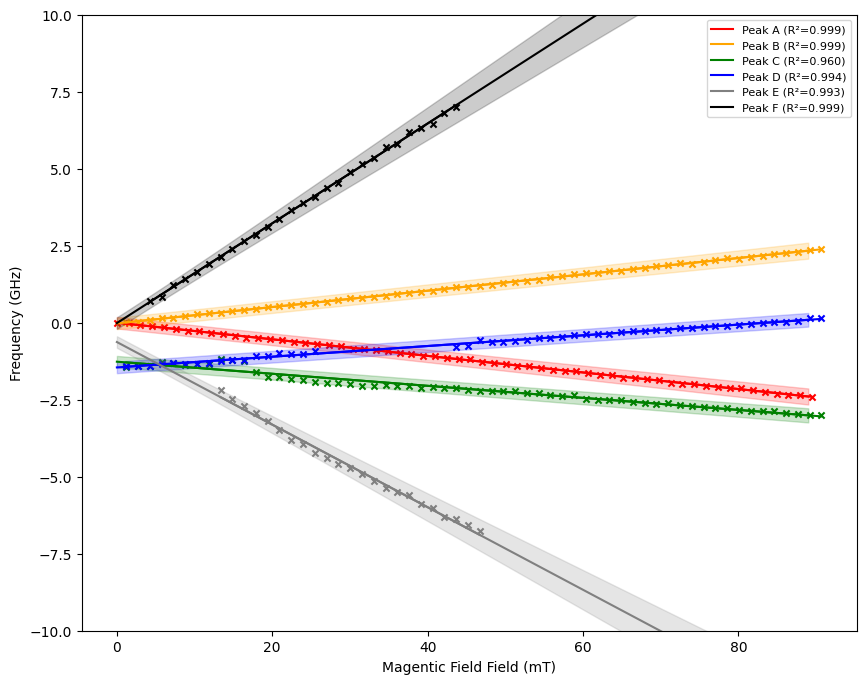

In [57]:
# Plot the data and linear fits
fig2, ax2 = plt.subplots(figsize=(10, 8))
#c = ax2.pcolormesh(fields * 1000,freq_axis_GHz, voltages.T, shading='auto', cmap='Blues')
# Plot the scatter points, linear fits, and extrapolated fits for each peak

uncert_f = 0.1875 #GHz
uncert_B_pct = 0.272/3.57220371#0.45 #%
colors = ['red', 'orange', 'green', 'blue', 'grey', 'k']
for i, (peak, data) in enumerate(peak_data.items()):
    freq_err = np.full_like(data['freq'], uncert_f)
    b_field = data['b_field']
    b_err = b_field * uncert_B_pct

    #ax2.errorbar(data['b_field'], data['freq'],xerr=b_err, yerr=freq_err,fmt=".",color=colors[i])#label=f"Peak {peak}"
    # Scatter plot of the original data points
    ax2.scatter(data['b_field'], data['freq'], color=colors[i], marker='x', s=20) #label=f"Peak {peak}"

    # Plot the fitted line within the original data range
    ax2.plot(data['b_field'], data['fit_line'], color=colors[i], label=f"Peak {peak} (R²={data['r_squared']:.3f})") # label=f"Fit {peak} (R²={data['r_squared']:.3f})"

    # Plot the extrapolated fit over the entire fields range
    ax2.plot(extrap_fields, data['extrapolated_fit'], color=colors[i])

        # Plot the extrapolated fit over the entire fields range
    #ax2.plot(extrap_fields, data['extrapolated_fit'], color=colors[i], linestyle='-')

    # --- Add shaded error region ---
    # Compute upper and lower bounds based on slope uncertainty
    slope = data['slope']
    intercept = data['intercept']
    slope_err = slopes[peak][0] * 0  # default fallback if not set
    if len(slopes[peak]) >= 4:
        slope_err = slopes[peak][2]  # slope_err is third if updated slopes[peak] has full info

    # Linear extrapolation with slope ± error
    # fit_upper = (slope + slope_err) * extrap_fields + intercept
    # fit_lower = (slope - slope_err) * extrap_fields + intercept

    # Total uncertainty in predicted frequency at each extrapolated B
    b_err_extrap = extrap_fields * uncert_B_pct  # extrapolated B uncertainty
    fit_center = slope * extrap_fields + intercept
    fit_err_band = np.sqrt((slope * b_err_extrap)**2 + uncert_f**2)

    fit_upper = fit_center + fit_err_band
    fit_lower = fit_center - fit_err_band

    peak_data[peak].update({
    "fit_upper": fit_upper,
    "fit_lower": fit_lower
    })

    # Shaded region between upper and lower
    ax2.fill_between(extrap_fields, fit_lower, fit_upper, color=colors[i], alpha=0.2)

# Add labels and legend
#fig2.colorbar(c, ax=ax2, label="Voltage")
ax2.set_ylim([-10,10])
ax2.set_xlabel("Magentic Field Field (mT)")
ax2.set_ylabel("Frequency (GHz)")
ax2.legend(fontsize=8)

In [ ]:
mf.apply_fig_style(fig2,ax2,style="large", line_size=0.8,marker_size=0.1)
mf.save_figure(fig2,"25_03_2025_IH_abosorption_site1_fitted_err2",folder=figure_save_path,dpi=1200)
fig2

Slope of deltaE = F-A_ground_o: 0.188925 GHz/mT, Intercept: -0.012526
Slope of deltaE = B-E_ground_o: 0.160584 GHz/mT, Intercept: 0.605044
Slope of deltaE = A-E_excited_o: 0.107143 GHz/mT, Intercept: 0.627021
Slope of deltaE = F-B_excited_o: 0.135484 GHz/mT, Intercept: 0.009451


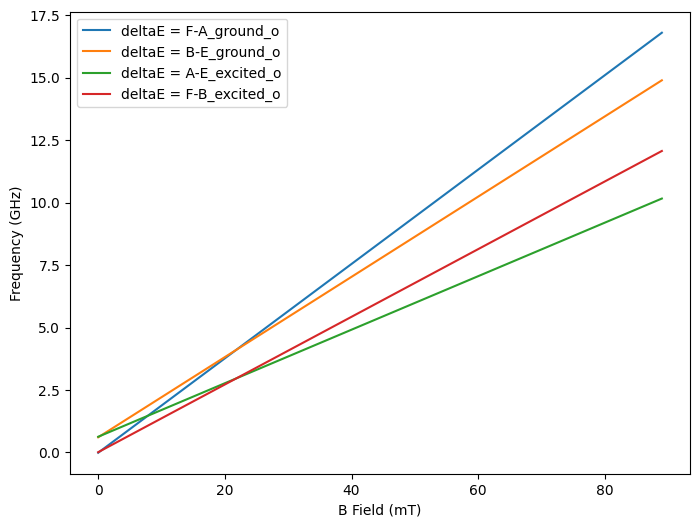

In [58]:
fig3, ax3 = plt.subplots(figsize=(8, 6))

# Get the extrapolated fit lines from the peak data
e2e_line = np.array(peak_data["A"]["extrapolated_fit"])
g2e_line = np.array(peak_data["F"]["extrapolated_fit"])
e2g_line = np.array(peak_data["E"]["extrapolated_fit"])
g2g_line = np.array(peak_data["B"]["extrapolated_fit"])

# Calculate the difference between lines
delta_E_abs_F_A = g2e_line - e2e_line
delta_E_abs_B_E = g2g_line - e2g_line
delta_E_abs_A_E = e2e_line - e2g_line
delta_E_abs_F_B = g2e_line - g2g_line

# Define a function to calculate the slope and plot the fitted line
def calculate_slope(x, y, label, units="GHz/mT"):
    # Perform linear fit
    fit = np.polyfit(x, y, 1)  # Degree 1 for linear fit
    slope, intercept = fit
    print(f"Slope of {label}: {slope:.6f} {units}, Intercept: {intercept:.6f}")
    
    # Plot the fitted line
    y_fit = np.poly1d(fit)(x)
   #ax3.plot(x, y_fit, linestyle='--', label=f"Fit {label} (Slope={slope:.3f})")
    return slope, intercept

# Plot the delta E lines
ax3.plot(extrap_fields, delta_E_abs_F_A, label="deltaE = F-A_ground_o")
ax3.plot(extrap_fields, delta_E_abs_B_E, label="deltaE = B-E_ground_o")
ax3.plot(extrap_fields, delta_E_abs_A_E, label="deltaE = A-E_excited_o")
ax3.plot(extrap_fields, delta_E_abs_F_B, label="deltaE = F-B_excited_o")

# Calculate slopes and plot fitted lines
slope_F_A, _ = calculate_slope(extrap_fields, delta_E_abs_F_A, "deltaE = F-A_ground_o")
slope_B_E, _ = calculate_slope(extrap_fields, delta_E_abs_B_E, "deltaE = B-E_ground_o")
slope_A_E, _ = calculate_slope(extrap_fields, delta_E_abs_A_E, "deltaE = A-E_excited_o")
slope_F_B, _ = calculate_slope(extrap_fields, delta_E_abs_F_B, "deltaE = F-B_excited_o")

# Plot settings
ax3.set_xlabel("B Field (mT)")
ax3.set_ylabel("Frequency (GHz)")
ax3.legend()
plt.show()


## G Tensor Calculations ## 

In [59]:
muB = 9.27400968e-24 #Bohr Magneton (J/T)
muN = 5.05078375e-27 #Nuclear Magneton (J/T)
hbar = 	1.054571817E-34 #Reduced planck constant (Js)
h = 2*np.pi*hbar #Planck constant (Js)
g_eff_F_A_ground_o = (h/muB)*slope_F_A*(10**9)/(10**(-3))
g_eff_B_E_ground_o = (h/muB)*slope_B_E*(10**9)/(10**(-3))
g_eff_F_A_excited_o =(h/muB)* slope_A_E*(10**9)/(10**(-3))
g_eff_A_E_excited_o = (h/muB)*slope_F_B*(10**9)/(10**(-3))

print("g_eff_F_A_ground_o = ",g_eff_F_A_ground_o )
print("g_eff_B_E_ground_o= ",g_eff_B_E_ground_o )
print("Average_Ground_o_ =", np.average([g_eff_F_A_ground_o,g_eff_B_E_ground_o]))
print("g_eff_F_A_excited_o = ",g_eff_F_A_excited_o )
print("g_eff_A_E_excited_o = ",g_eff_A_E_excited_o )
print("Average_Ground_o_ =", np.average([g_eff_F_A_excited_o,g_eff_A_E_excited_o]))

#  Can I calculate full g tensor ? 

g_eff_F_A_ground_o =  13.49824148929496
g_eff_B_E_ground_o=  11.473370098676751
Average_Ground_o_ = 12.485805793985856
g_eff_F_A_excited_o =  7.6551188549894205
g_eff_A_E_excited_o =  9.679990245607625
Average_Ground_o_ = 8.667554550298522


## G TENSORS WITH UNCERT ## 

In [60]:
# ---- Compute g_eff from extrapolated slopes (including slope uncertainty from fill_between) ----

def get_delta_slope_and_error(peak1, peak2, label):
    y = np.array(peak_data[peak1]["extrapolated_fit"]) - np.array(peak_data[peak2]["extrapolated_fit"])
    y_upper = np.array(peak_data[peak1]["fit_upper"]) - np.array(peak_data[peak2]["fit_lower"])
    y_lower = np.array(peak_data[peak1]["fit_lower"]) - np.array(peak_data[peak2]["fit_upper"])

    m = np.polyfit(extrap_fields, y, 1)[0]
    m_upper = np.polyfit(extrap_fields, y_upper, 1)[0]
    m_lower = np.polyfit(extrap_fields, y_lower, 1)[0]
    m_err = np.abs(m_upper - m_lower) / 2

    print(f"{label}: slope = {m:.6f} ± {m_err:.6f} GHz/mT")
    return m, m_err


# Run this for each deltaE line
slope_F_A, slope_F_A_err = get_delta_slope_and_error("F", "A", "deltaE = F-A_ground_o")
slope_B_E, slope_B_E_err = get_delta_slope_and_error("B", "E", "deltaE = B-E_ground_o")
slope_A_E, slope_A_E_err = get_delta_slope_and_error("A", "E", "deltaE = A-E_excited_o")
slope_F_B, slope_F_B_err = get_delta_slope_and_error("F", "B", "deltaE = F-B_excited_o")


# ---- Physical constants ----
muB = 9.27400968e-24  # Bohr Magneton (J/T)
hbar = 1.054571817E-34  # Reduced Planck constant (Js)
h = 2 * np.pi * hbar
scale = (h / muB) * 1e9 / 1e-3  # Converts GHz/mT to unitless g_eff

# ---- Convert slopes to g_eff with uncertainty ----
g_eff_F_A = slope_F_A * scale
g_eff_F_A_err = slope_F_A_err * scale

g_eff_B_E = slope_B_E * scale
g_eff_B_E_err = slope_B_E_err * scale

g_eff_A_E = slope_A_E * scale
g_eff_A_E_err = slope_A_E_err * scale

g_eff_F_B = slope_F_B * scale
g_eff_F_B_err = slope_F_B_err * scale

# ---- Averages with propagated error ----
avg_ground = np.mean([g_eff_F_A, g_eff_B_E])
avg_ground_err = np.sqrt(g_eff_F_A_err**2 + g_eff_B_E_err**2) / 2

avg_excited = np.mean([g_eff_A_E, g_eff_F_B])
avg_excited_err = np.sqrt(g_eff_A_E_err**2 + g_eff_F_B_err**2) / 2

# ---- Output ----
print("\n---- g_eff Results ----")
print(f"g_eff_F_A_ground_o     = {g_eff_F_A:.3f} ± {g_eff_F_A_err:.3f}")
print(f"g_eff_B_E_ground_o     = {g_eff_B_E:.3f} ± {g_eff_B_E_err:.3f}")
print(f"Average Ground g_eff   = {avg_ground:.3f} ± {avg_ground_err:.3f}")
print("")
print(f"g_eff_A_E_excited_o    = {g_eff_A_E:.3f} ± {g_eff_A_E_err:.3f}")
print(f"g_eff_F_B_excited_o    = {g_eff_F_B:.3f} ± {g_eff_F_B_err:.3f}")
print(f"Average Excited g_eff  = {avg_excited:.3f} ± {avg_excited_err:.3f}")


deltaE = F-A_ground_o: slope = 0.188925 ± 0.011899 GHz/mT
deltaE = B-E_ground_o: slope = 0.160584 ± 0.009680 GHz/mT
deltaE = A-E_excited_o: slope = 0.107143 ± 0.009701 GHz/mT
deltaE = F-B_excited_o: slope = 0.135484 ± 0.011879 GHz/mT

---- g_eff Results ----
g_eff_F_A_ground_o     = 13.498 ± 0.850
g_eff_B_E_ground_o     = 11.473 ± 0.692
Average Ground g_eff   = 12.486 ± 0.548

g_eff_A_E_excited_o    = 7.655 ± 0.693
g_eff_F_B_excited_o    = 9.680 ± 0.849
Average Excited g_eff  = 8.668 ± 0.548


## Global Magnetic Field Inhomogeniety ## 
- The Zero field splitting is characterisitc of strain on the crystal. Meaning that part of the crystal is under a an amount of stress. 
- The gradient of the that absopriton line as compared to the other line should give us an estimate on the magnetic field homoegenity across the crystal if we assume the starin and the unstrained part are at the length of the crystal. This should give use b-axis magnetic field gradient. 

$$\Delta B = B(\frac{m'-m}{m})$$
See notes for derivation.

In [256]:


def calculate_homogeneity_features(target_B_field, slope_strained, slope_unstrained): # Slope GHz/mt
    delta_B = target_B_field*np.abs((slope_strained-slope_unstrained)/slope_unstrained)
    delta_f_strained = slope_strained*delta_B
    delta_f_unstrained = slope_unstrained*delta_B
    return delta_B, np.abs(delta_f_strained), np.abs(delta_f_unstrained) # GHZ and MT

    
target_field = 60 #mt 
## Get Slopes of Lines ## 
print("Peak Pair 1")
print("Slope of Strained A = ", peak_data["A"]["slope"], "GHz/mT")
print("Slope of Unstrained C = ", peak_data["C"]["slope"], "GHz/mT")
print("Slope Difference abs(A-C) =", np.abs(peak_data["A"]["slope"]-peak_data["C"]["slope"]), "GHz/mT")
delta_B_1, delta_f_strained_1, delta_f_unstrained_1 = calculate_homogeneity_features(target_field, peak_data["A"]["slope"],peak_data["C"]["slope"] )
print(f"At B ={target_field}, Field Grad = {delta_B_1} mT, Strained FWHM = {delta_f_strained_1*1000} MHz, Unstrained FWHM = {delta_f_unstrained_1*1000} MHz") 
print("\n")
print("Peak Pair 2")
print("Slope of Strained B = ", peak_data["B"]["slope"], "GHz/mT")
print("Slope of Unstrained D = ", peak_data["D"]["slope"], "GHz/mT")
print("Slope Difference abs(B-D) =", np.abs(peak_data["B"]["slope"]-peak_data["D"]["slope"]), "GHz/mT")
delta_B_2, delta_f_strained_2, delta_f_unstrained_2 = calculate_homogeneity_features(target_field, peak_data["B"]["slope"],peak_data["D"]["slope"])
print(f"At B ={target_field}, Field Grad = {delta_B_2} mT, Strained FWHM = {delta_f_strained_2*1000} MHz, Unstrained FWHM = {delta_f_unstrained_2*1000} MHz ") 

## Average ## 
delta_B_av= np.average([delta_B_1, delta_B_2])
delta_f_strained_av = np.average([delta_f_strained_1, delta_f_strained_2])
delta_f_unstrained_av = np.average([delta_f_unstrained_1, delta_f_unstrained_2])
print("\n")
print("AVERAGE")
print(f"At B = {target_field} mT, Field Grad = {delta_B_av} mT over 5.8mm, Strained FWHM = {delta_f_strained_av*1000} MHz, Unstrained FWHM = {delta_f_unstrained_av*1000} MHz ") 




Peak Pair 1
Slope of Strained A =  -0.026908986888908498 GHz/mT
Slope of Unstrained C =  -0.019575765693244564 GHz/mT
Slope Difference abs(A-C) = 0.007333221195663934 GHz/mT
At B =60, Field Grad = 22.476427161757154 mT, Strained FWHM = 604.8178838052302 MHz, Unstrained FWHM = 439.99327173983596 MHz


Peak Pair 2
Slope of Strained B =  0.02653219048275734 GHz/mT
Slope of Unstrained D =  0.01736897005185176 GHz/mT
Slope Difference abs(B-D) = 0.009163220430905582 GHz/mT
At B =60, Field Grad = 31.653760943396858 mT, Strained FWHM = 839.8436148458701 MHz, Unstrained FWHM = 549.7932258543349 MHz 


AVERAGE
At B = 60 mT, Field Grad = 27.065094052577006 mT over 5.8mm, Strained FWHM = 722.3307493255502 MHz, Unstrained FWHM = 494.8932487970854 MHz 


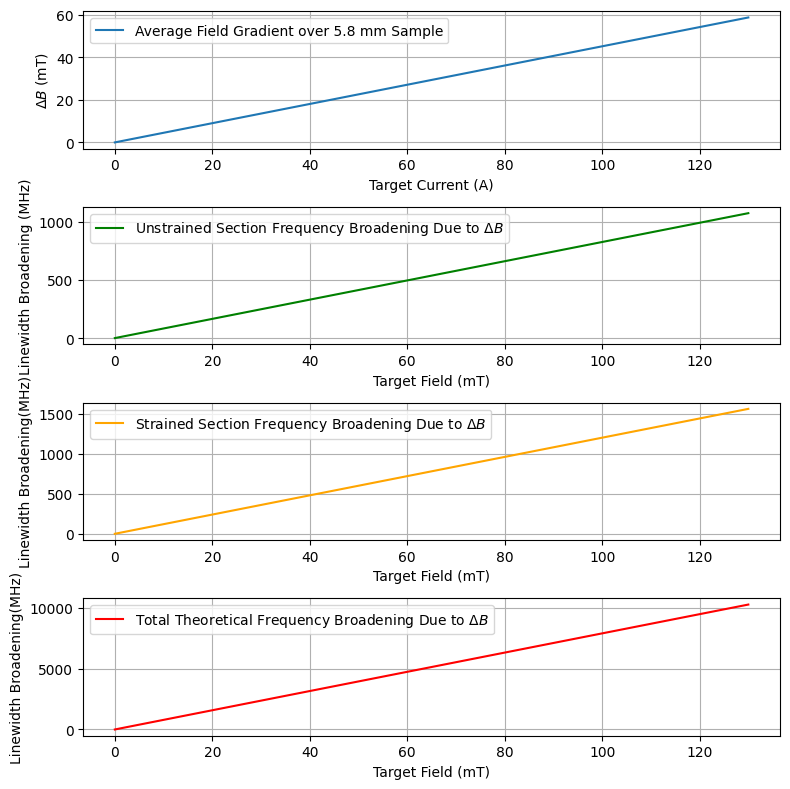

In [257]:
## Plot ## 
target_fields=np.arange(0,140,10)

delta_B_1, delta_f_strained_1, delta_f_unstrained_1 = calculate_homogeneity_features(target_fields, peak_data["A"]["slope"],peak_data["C"]["slope"] )
delta_B_2, delta_f_strained_2, delta_f_unstrained_2 = calculate_homogeneity_features(target_fields, peak_data["B"]["slope"],peak_data["D"]["slope"])
delta_B_av =[]
delta_f_strained_av =[]
delta_f_unstrained_av =[]
delta_f_theoretical =[]
g_estimate = 12.485805793985854
#g_estimate = 4.4

for i in range(0,len(target_fields)): 
    delta_B_av.append(np.average([delta_B_1[i], delta_B_2[i]]))
    delta_f_unstrained_av.append(np.average([delta_f_unstrained_1[i], delta_f_unstrained_2[i]]))
    delta_f_strained_av.append(np.average([delta_f_strained_1[i], delta_f_strained_2[i]]))
    delta_f_theoretical.append((muB/h)*g_estimate*delta_B_av[i]*10**(-3)/(10**9))


delta_f_theoretical= np.array(delta_f_theoretical)
delta_B_av =np.array(delta_B_av)
delta_f_strained_av =np.array(delta_f_strained_av)
delta_f_unstrained_av = np.array(delta_f_unstrained_av)
# delta_B_av= np.average([delta_B_1, delta_B_2])
# delta_f_strained_av = np.average([delta_f_strained_1, delta_f_strained_2])
# delta_f_unstrained_av = np.average([delta_f_unstrained_1, delta_f_unstrained_2])
coil_const_used = 3.57220371 # mT/A
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8,8 )) 
ax1.plot(target_fields, delta_B_av, label="Average Field Gradient over 5.8 mm Sample")
ax1.grid() 
ax1.set_xlabel(r"Target Current (mT)")
#ax1.set_xlabel(r"Target Field (mT)")
ax1.set_ylabel(r"$\Delta B$ (mT)")
ax1.legend()


ax2.plot(target_fields, delta_f_unstrained_av*1000,color ="green", label=r"Unstrained Section Frequency Broadening Due to $\Delta B$")
ax2.grid() 
ax2.set_xlabel(r"Target Field (mT)")
ax2.set_ylabel(r"Linewidth Broadening (MHz)")
ax2.legend()


ax3.plot(target_fields, delta_f_strained_av*1000, color="orange", label=r"Strained Section Frequency Broadening Due to $\Delta B$")
ax3.grid() 
ax3.set_xlabel(r"Target Field (mT)")
ax3.set_ylabel(r"Linewidth Broadening(MHz)")
ax3.legend()

ax4.plot(target_fields, delta_f_theoretical*1000, color="red", label=r"Total Theoretical Frequency Broadening Due to $\Delta B$")
ax4.grid() 
ax4.set_xlabel(r"Target Field (mT)")
ax4.set_ylabel(r"Linewidth Broadening(MHz)")
ax4.legend()
plt.tight_layout()

In [275]:
#Pecentage#
slope, intercept = calculate_slope(target_fields, delta_B_av,"delta B  v amp", units="mT/mT")
print("Field Variation across sample", slope*100, "%")

Slope of delta B  v amp: 0.451085 mT/mT, Intercept: -0.000000
Field Variation across sample 45.10849008762834 %


In [258]:
## COIL CONSTANT ## 
slope, intercept = calculate_slope(target_fields/coil_const_used, delta_B_av,"delta B  v amp", units="mT/A")
print("Max Coil Constant Estimate in Sample =", coil_const_used+slope/2, "mt/A")
print("Min Coil Constant Estimate in Sample =", coil_const_used-slope/2, "mT/A")

print("Coil Constant Field Variation across sample", slope/5.8, "mt/(A mm)")

Slope of delta B  v amp: 1.611367 mT/A, Intercept: -0.000000
Max Coil Constant Estimate in Sample = 4.377887288217622 mt/A
Min Coil Constant Estimate in Sample = 2.766520131782379 mT/A
Coil Constant Field Variation across sample 0.27782192352331764 mt/(A mm)


In [259]:
def get_field_homogeneity_features(target_field, peak_data, g_estimate=12.485805793985854, muB=9.2740100783e-24, h=6.62607015e-34):
    """
    For a given target magnetic field (in mT), return average ΔB and expected frequency broadenings.
    """
    if not isinstance(target_field, (int, float)):
        raise ValueError("target_field must be a float or int representing field in mT")

    # Run homogeneity calculations for strained/unstrained peak pairs
    delta_B_1, delta_f_strained_1, delta_f_unstrained_1 = calculate_homogeneity_features(target_field, peak_data["A"]["slope"],peak_data["C"]["slope"] )
    delta_B_2, delta_f_strained_2, delta_f_unstrained_2 = calculate_homogeneity_features(target_field, peak_data["B"]["slope"],peak_data["D"]["slope"])

    # Compute averages
    delta_B_av = np.average([delta_B_1, delta_B_2])
    delta_f_strained_av = np.average([delta_f_strained_1, delta_f_strained_2])*1e9
    delta_f_unstrained_av = np.average([delta_f_unstrained_1, delta_f_unstrained_2])*1e9# convert to Hz 

    # Theoretical frequency broadening: Δf = (μB / h) * g * ΔB
    delta_f_theoretical = (muB / h) * g_estimate * delta_B_av * 1e-3  # convert mT → T
    return {
        "delta_B_av (mT)": delta_B_av,
        # "delta_f_unstrained (Hz)": delta_f_unstrained_av,
        # "delta_f_strained (Hz)": delta_f_strained_av,
        "delta_f_theoretical (Hz)": delta_f_theoretical
    }

target_field = 60.03
result = get_field_homogeneity_features(target_field, peak_data,g_estimate=4.4)
for key, val in result.items():
    if 'Hz' in key:
        print(f"{key}: {val/1e6:.3f} MHz")
    else:
        print(f"{key}: {val:.3f}")

delta_B_av (mT): 27.079
delta_f_theoretical (Hz): 1667.596 MHz


## WIP: Local Magnetic Field Inhomogeneity ##
- We can work out the local inhomogeneity caused by the field gradients at each of the strain points by directly fitting lorentzians to each peaks and calculuting the FWHM.


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 21-07-47_freq_195.11847_rng_36.6852_gain_30_fld_0.0.csv


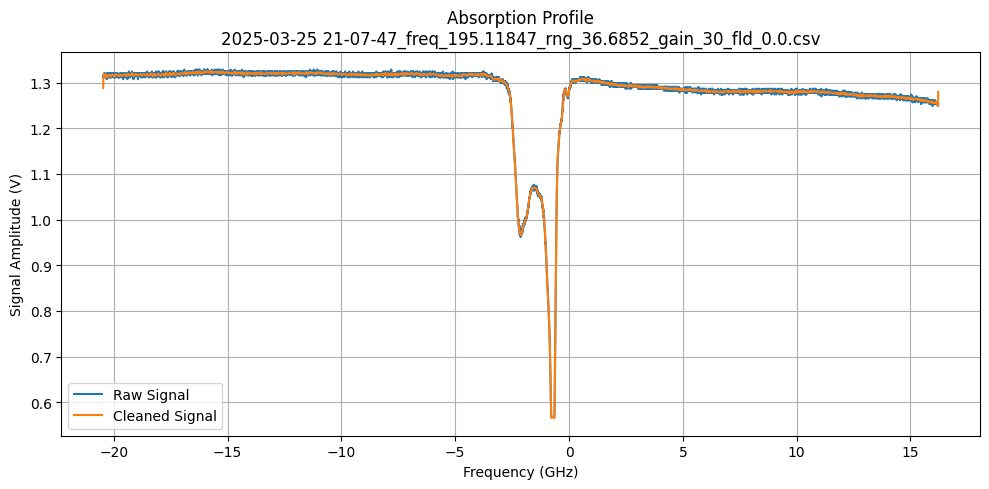


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.027593 GHz
  FWHM:   61431.94 MHz
  Depth:  1077.0863
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.027593 GHz
  FWHM:   61431.94 MHz
  Depth:  1077.0863
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -2.026002 GHz
  FWHM:   63526.84 MHz
  Depth:  1146.7526
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.027593 GHz
  FWHM:   61431.94 MHz
  Depth:  1077.0863
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -2.026002 GHz
  FWHM:   63526.84 MHz
  Depth:  1146.7526
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -2.024339 GHz
  FWHM:   64206.09 MHz
  Depth:  1164.9842
#################

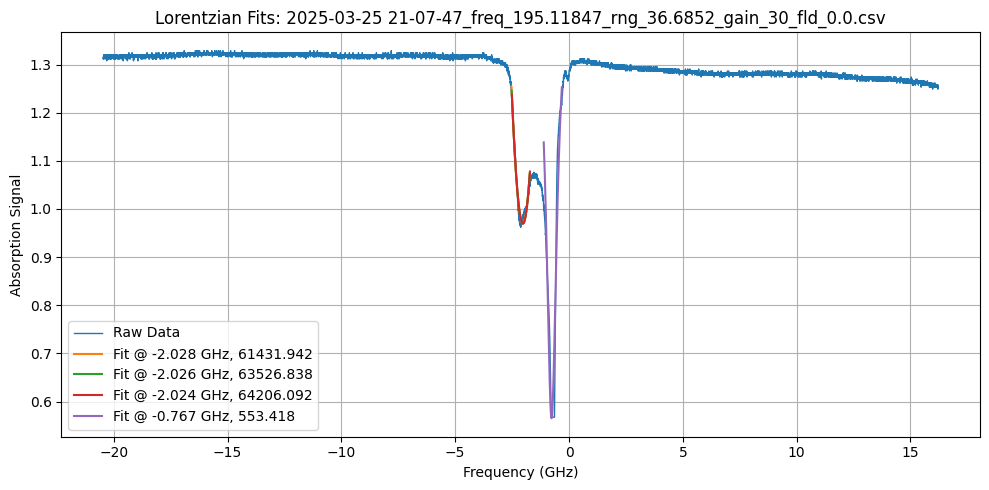


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 21-00-15_freq_195.11847_rng_36.6852_gain_30_fld_0.010616666666666667.csv


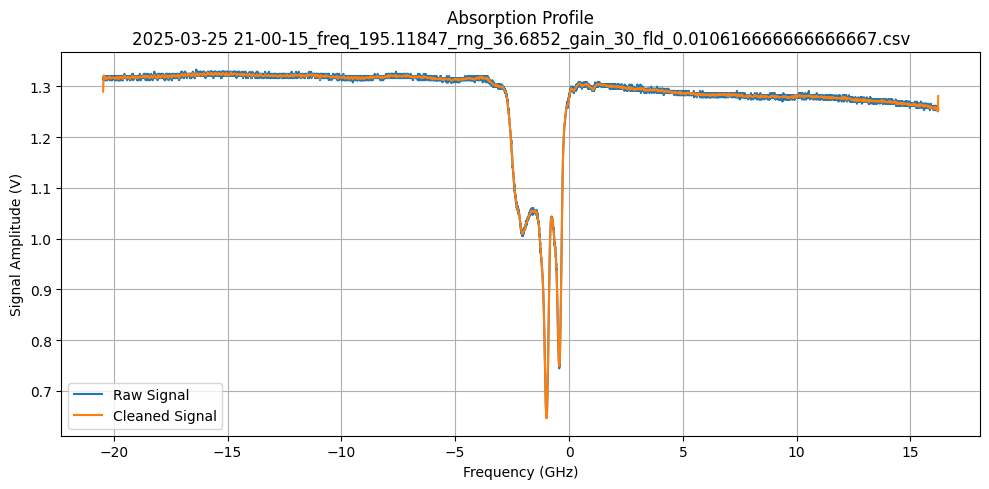


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.978045 GHz
  FWHM:   3560.66 MHz
  Depth:  1.5740
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.978045 GHz
  FWHM:   3560.66 MHz
  Depth:  1.5740
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.976085 GHz
  FWHM:   2978.97 MHz
  Depth:  1.1041
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.978045 GHz
  FWHM:   3560.66 MHz
  Depth:  1.5740
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.976085 GHz
  FWHM:   2978.97 MHz
  Depth:  1.1041
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -1.970706 GHz
  FWHM:   2204.36 MHz
  Depth:  0.6048
#########################################

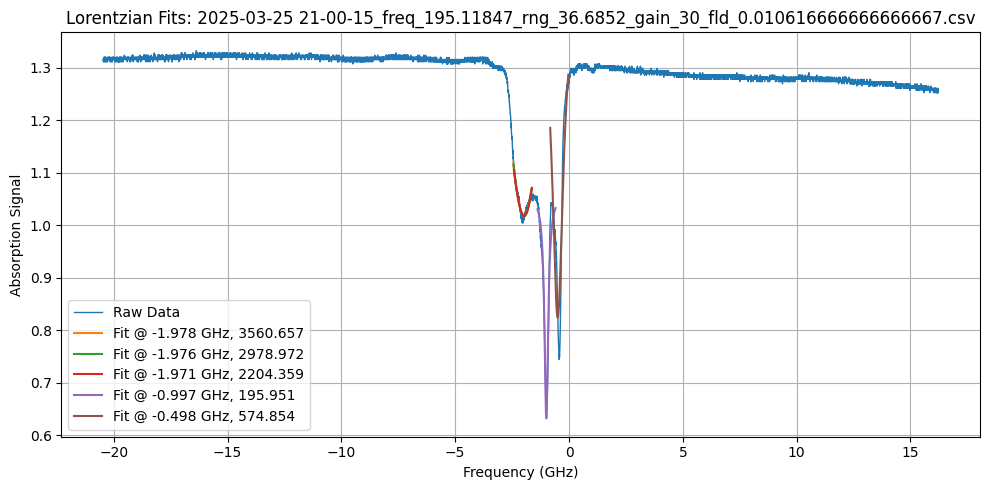


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-53-28_freq_195.11847_rng_36.6852_gain_30_fld_0.02002.csv


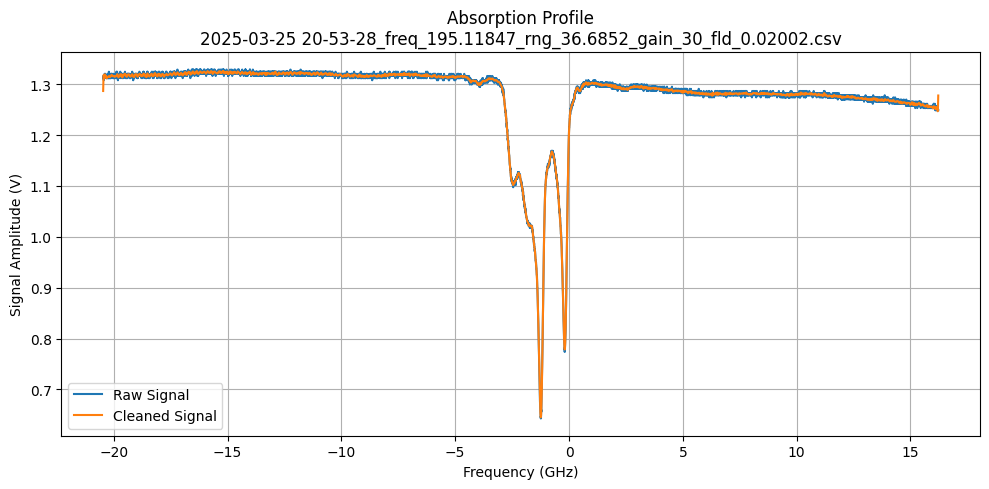


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.265001 GHz
  FWHM:   277.55 MHz
  Depth:  0.5111
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.265001 GHz
  FWHM:   277.55 MHz
  Depth:  0.5111
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.265467 GHz
  FWHM:   283.96 MHz
  Depth:  0.5165
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.265001 GHz
  FWHM:   277.55 MHz
  Depth:  0.5111
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.265467 GHz
  FWHM:   283.96 MHz
  Depth:  0.5165
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -0.230430 GHz
  FWHM:   367.55 MHz
  Depth:  0.5231
#########################################



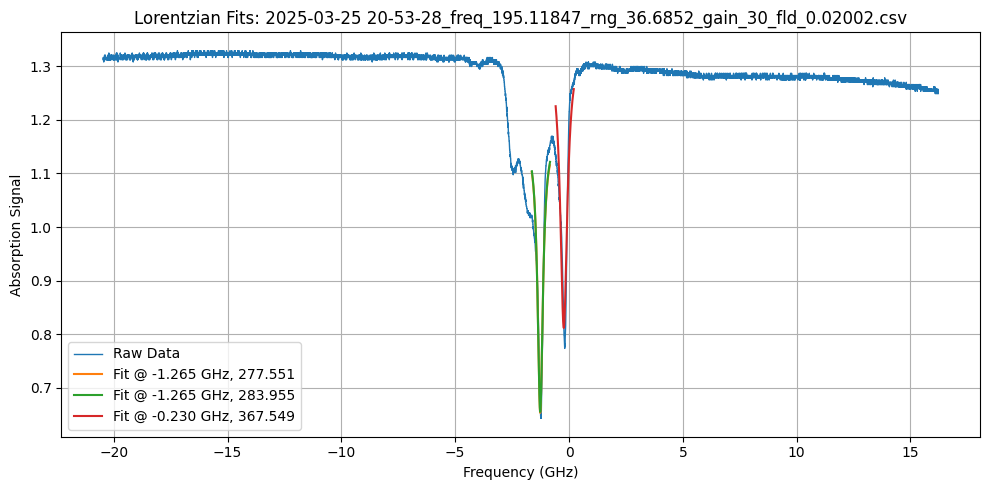


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-44-01_freq_195.11847_rng_36.6852_gain_30_fld_0.03306333333333333.csv


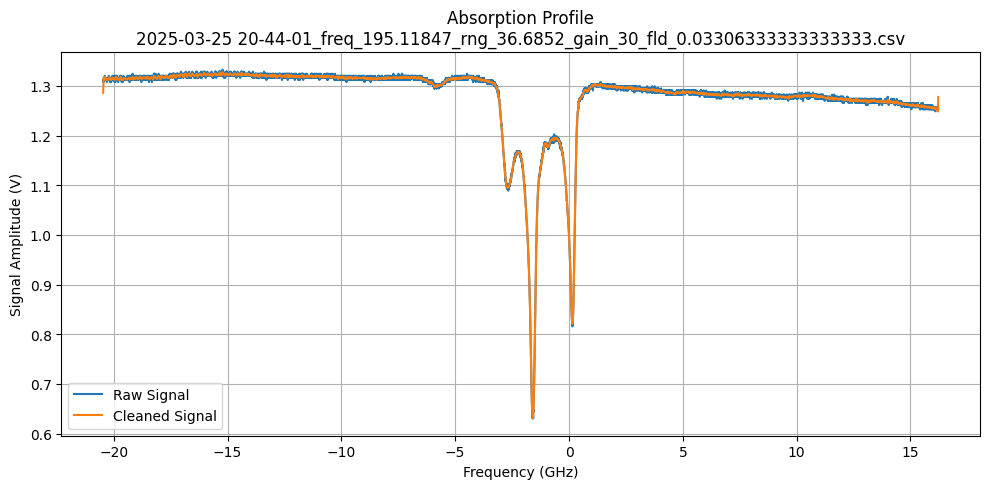


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.610874 GHz
  FWHM:   23398.60 MHz
  Depth:  117.0542
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.610874 GHz
  FWHM:   23398.60 MHz
  Depth:  117.0542
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.603488 GHz
  FWHM:   287.83 MHz
  Depth:  0.5752
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.610874 GHz
  FWHM:   23398.60 MHz
  Depth:  117.0542
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.603488 GHz
  FWHM:   287.83 MHz
  Depth:  0.5752
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -1.603547 GHz
  FWHM:   289.56 MHz
  Depth:  0.5770
###################################

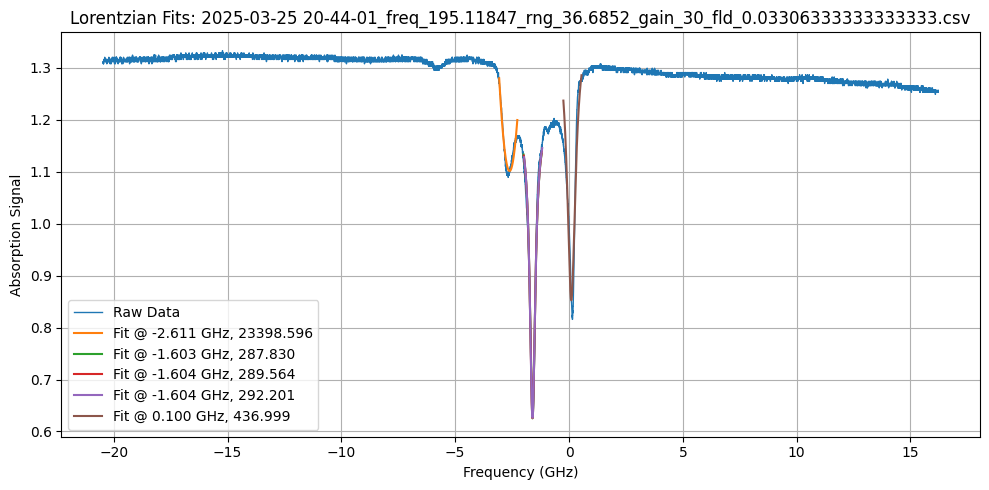


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-37-15_freq_195.11847_rng_36.6852_gain_30_fld_0.04216333333333334.csv


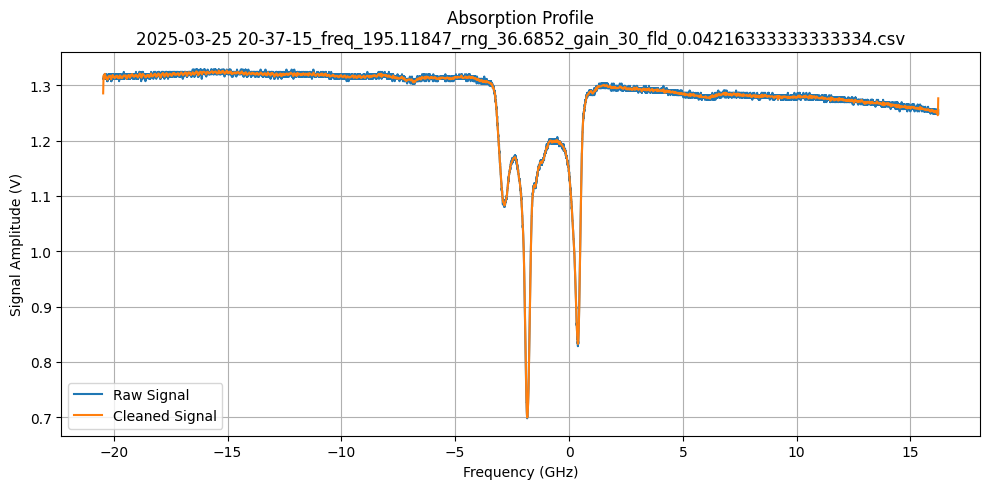


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.783527 GHz
  FWHM:   1996.37 MHz
  Depth:  1.1172
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.783527 GHz
  FWHM:   1996.37 MHz
  Depth:  1.1172
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -2.781089 GHz
  FWHM:   2282.46 MHz
  Depth:  1.3936
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.783527 GHz
  FWHM:   1996.37 MHz
  Depth:  1.1172
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -2.781089 GHz
  FWHM:   2282.46 MHz
  Depth:  1.3936
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -2.776084 GHz
  FWHM:   3551.56 MHz
  Depth:  3.0692
#########################################

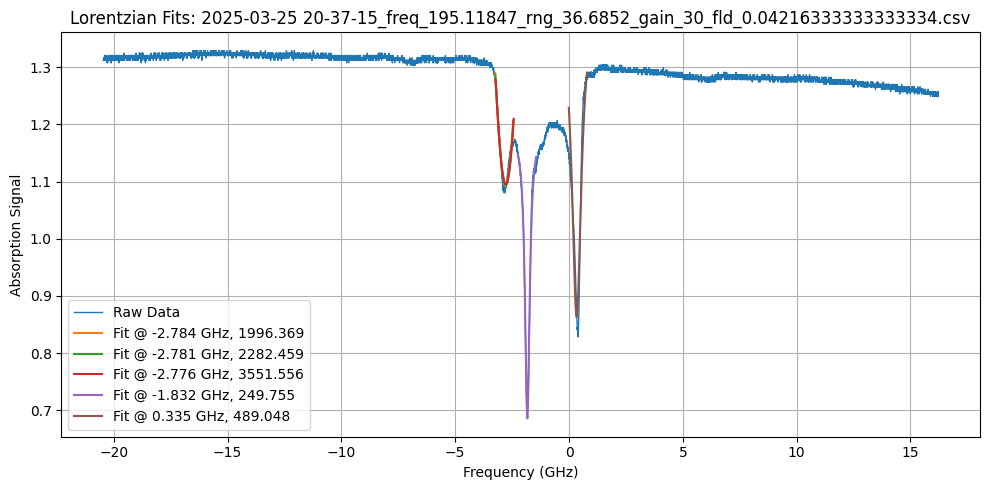


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-30-50_freq_195.11847_rng_36.6852_gain_30_fld_0.050960000000000005.csv


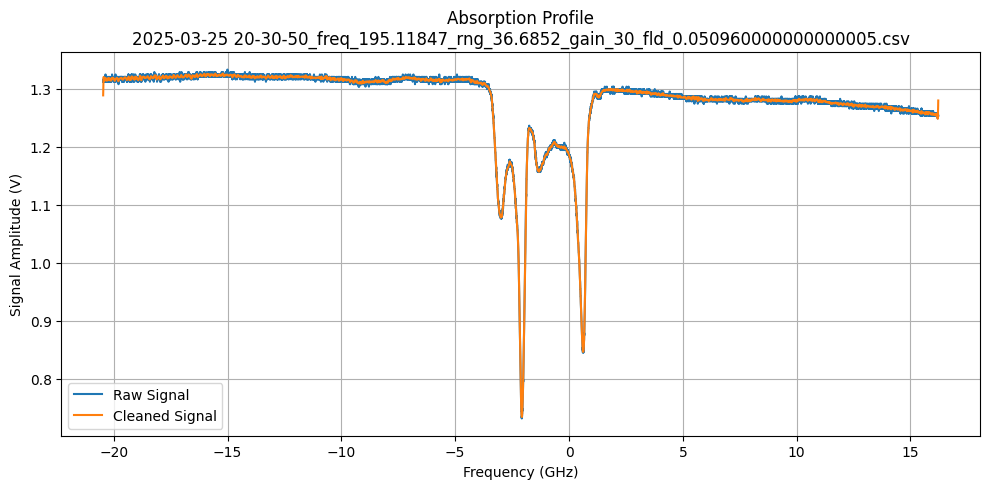


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.948569 GHz
  FWHM:   1667.83 MHz
  Depth:  0.8901
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.948569 GHz
  FWHM:   1667.83 MHz
  Depth:  0.8901
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -2.943966 GHz
  FWHM:   1943.65 MHz
  Depth:  1.1177
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.948569 GHz
  FWHM:   1667.83 MHz
  Depth:  0.8901
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -2.943966 GHz
  FWHM:   1943.65 MHz
  Depth:  1.1177
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -2.939078 GHz
  FWHM:   2140.07 MHz
  Depth:  1.2722
#########################################

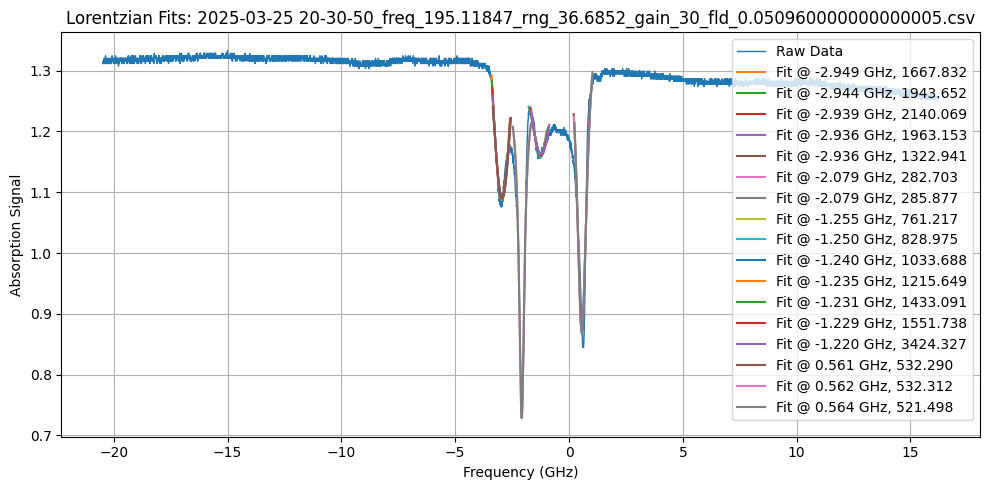


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-23-39_freq_195.11847_rng_36.6852_gain_30_fld_0.06097.csv


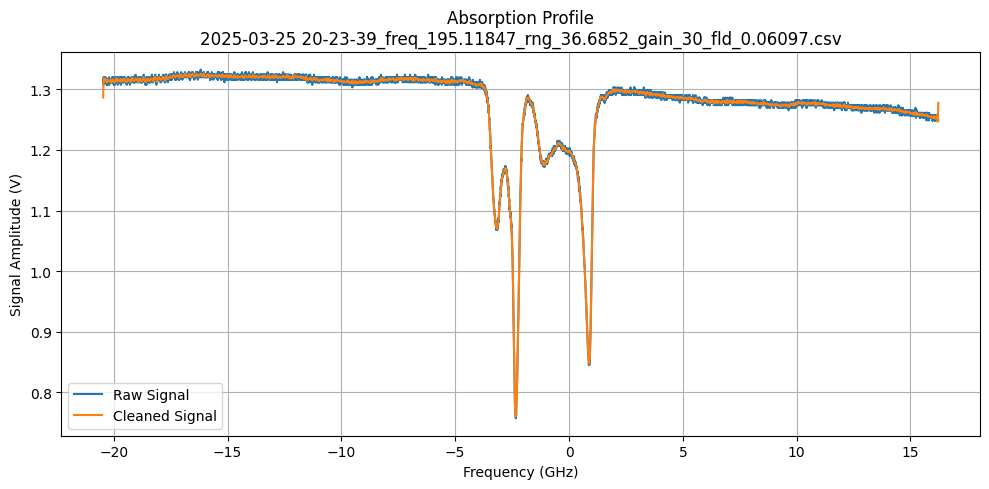


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.134278 GHz
  FWHM:   1347.56 MHz
  Depth:  0.6738
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.134278 GHz
  FWHM:   1347.56 MHz
  Depth:  0.6738
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -3.131740 GHz
  FWHM:   1460.78 MHz
  Depth:  0.7516
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.134278 GHz
  FWHM:   1347.56 MHz
  Depth:  0.6738
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -3.131740 GHz
  FWHM:   1460.78 MHz
  Depth:  0.7516
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -3.125314 GHz
  FWHM:   1732.57 MHz
  Depth:  0.9483
#########################################

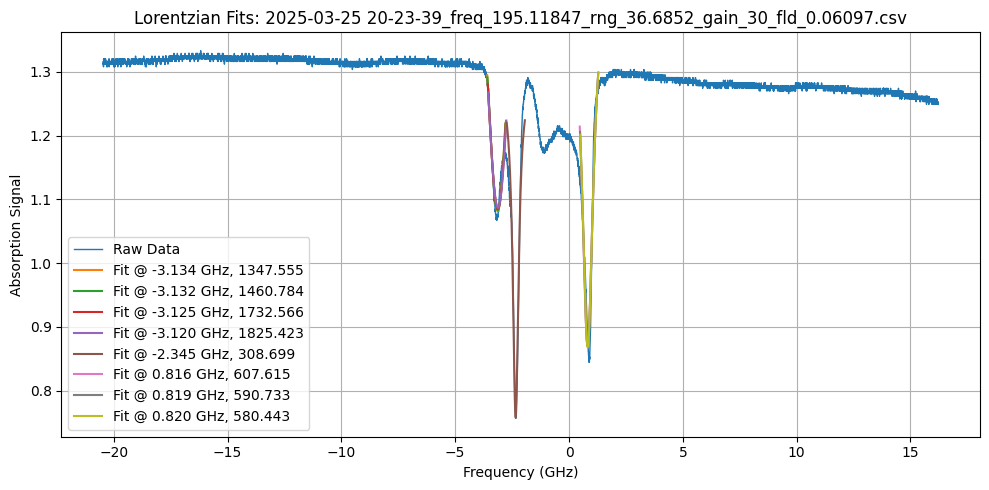


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-17-09_freq_195.11847_rng_36.6852_gain_30_fld_0.07007000000000001.csv


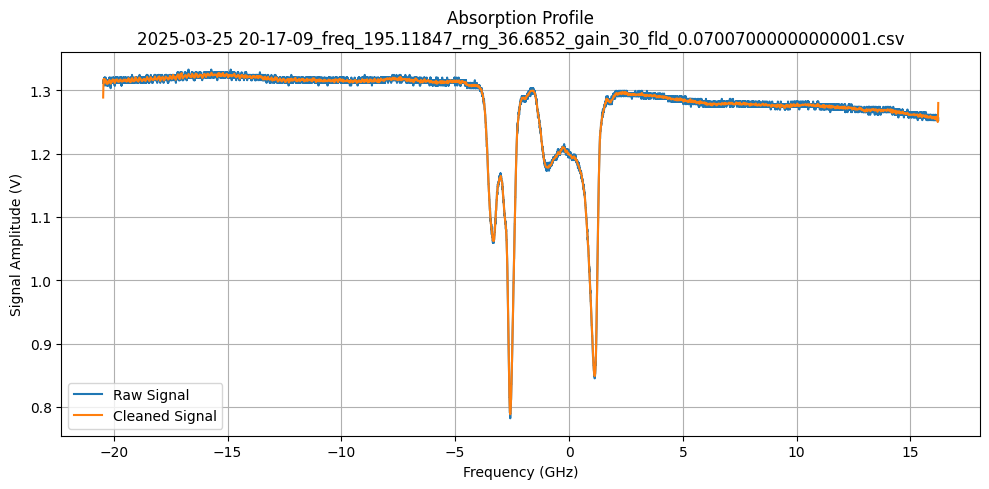


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.291084 GHz
  FWHM:   1393.15 MHz
  Depth:  0.7083
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.291084 GHz
  FWHM:   1393.15 MHz
  Depth:  0.7083
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -3.287882 GHz
  FWHM:   1535.04 MHz
  Depth:  0.8076
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.291084 GHz
  FWHM:   1393.15 MHz
  Depth:  0.7083
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -3.287882 GHz
  FWHM:   1535.04 MHz
  Depth:  0.8076
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -3.279133 GHz
  FWHM:   1936.68 MHz
  Depth:  1.1119
#########################################

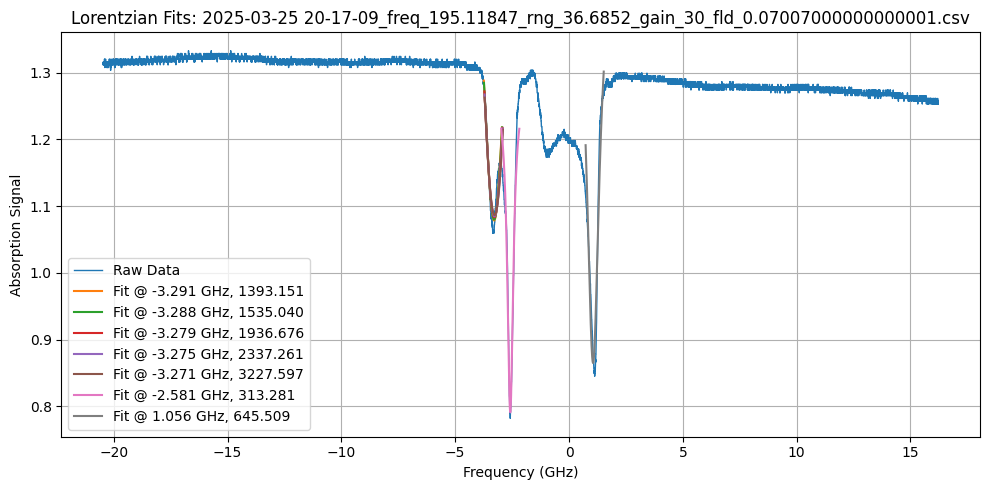


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-10-38_freq_195.11847_rng_36.6852_gain_30_fld_0.07886666666666667.csv


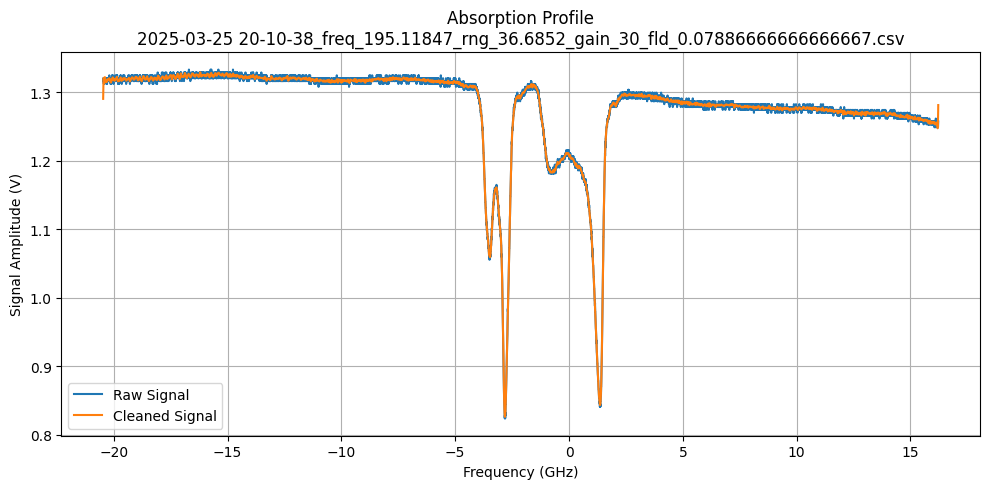


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.432817 GHz
  FWHM:   2255.82 MHz
  Depth:  1.4450
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.432817 GHz
  FWHM:   2255.82 MHz
  Depth:  1.4450
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -2.812483 GHz
  FWHM:   321.50 MHz
  Depth:  0.4448
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.432817 GHz
  FWHM:   2255.82 MHz
  Depth:  1.4450
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -2.812483 GHz
  FWHM:   321.50 MHz
  Depth:  0.4448
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -2.812873 GHz
  FWHM:   331.54 MHz
  Depth:  0.4524
#########################################




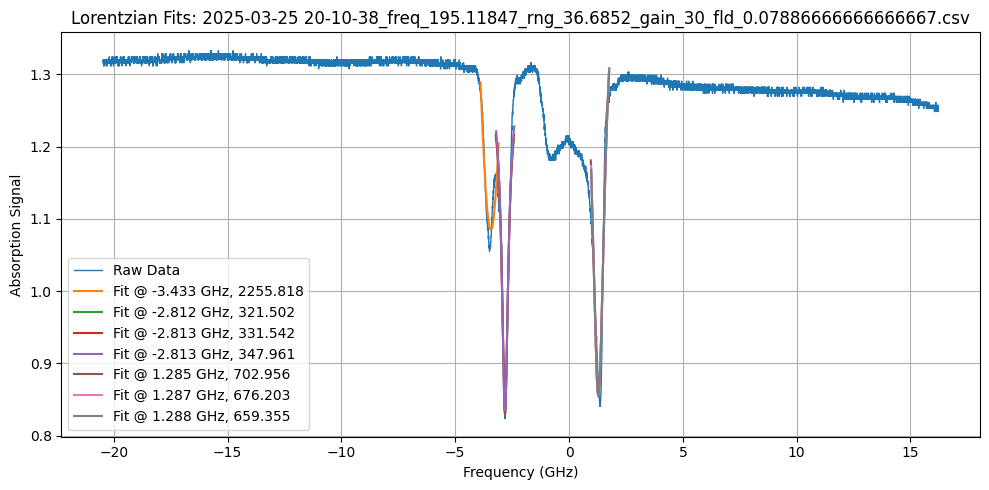


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-06-22_freq_195.11847_rng_36.6852_gain_30_fld_0.08463000000000001.csv


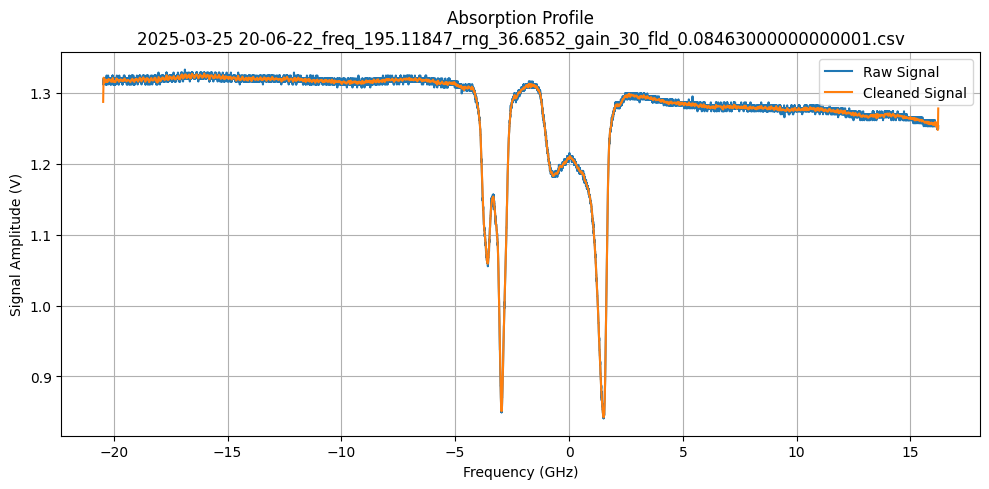


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.495050 GHz
  FWHM:   88364.82 MHz
  Depth:  1605.0208
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.495050 GHz
  FWHM:   88364.82 MHz
  Depth:  1605.0208
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -2.964401 GHz
  FWHM:   333.08 MHz
  Depth:  0.4116
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.495050 GHz
  FWHM:   88364.82 MHz
  Depth:  1605.0208
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -2.964401 GHz
  FWHM:   333.08 MHz
  Depth:  0.4116
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -2.964871 GHz
  FWHM:   346.47 MHz
  Depth:  0.4209
################################

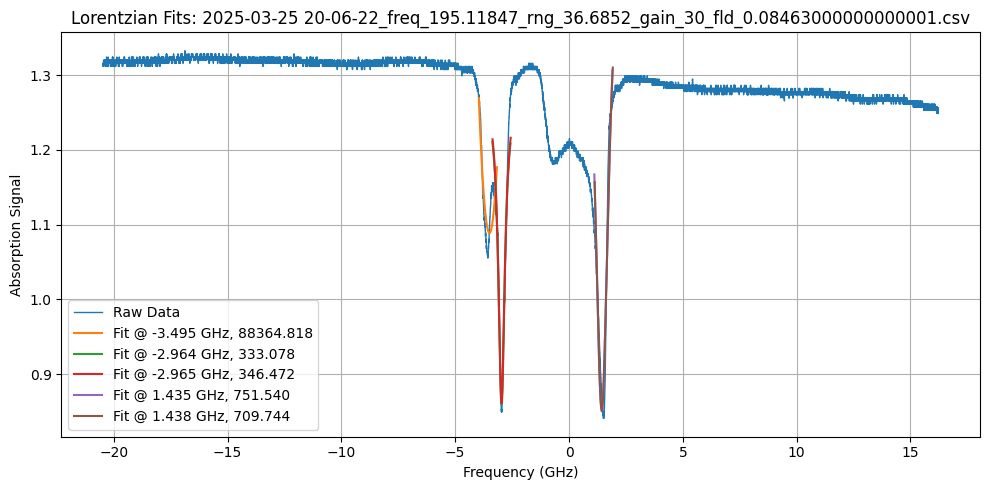


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-02-00_freq_195.11847_rng_36.6852_gain_30_fld_0.09069666666666668.csv


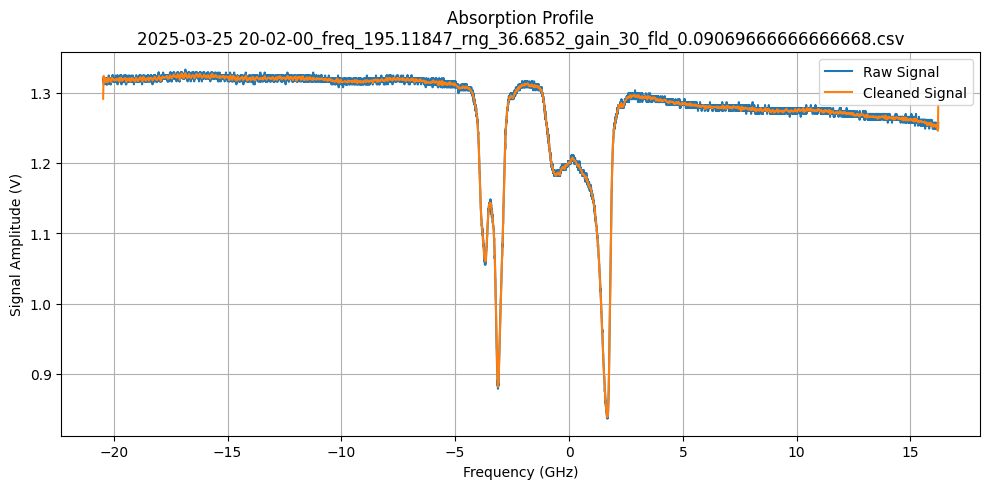


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.602468 GHz
  FWHM:   70652.80 MHz
  Depth:  1087.0754
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.602468 GHz
  FWHM:   70652.80 MHz
  Depth:  1087.0754
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -3.581641 GHz
  FWHM:   93071.70 MHz
  Depth:  1693.8225
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -3.602468 GHz
  FWHM:   70652.80 MHz
  Depth:  1087.0754
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -3.581641 GHz
  FWHM:   93071.70 MHz
  Depth:  1693.8225
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -3.118709 GHz
  FWHM:   334.28 MHz
  Depth:  0.3707
######################

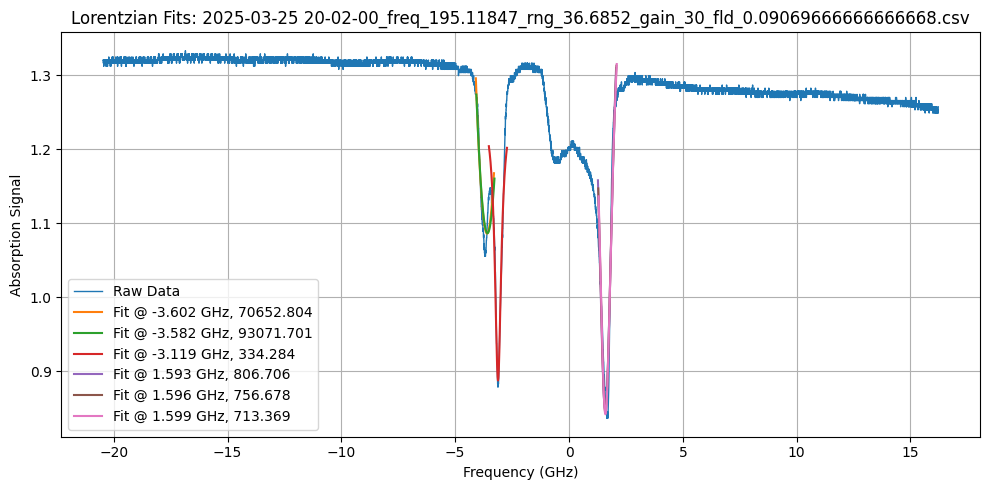

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === List of data files === #
data_files = [
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 21-07-47_freq_195.11847_rng_36.6852_gain_30_fld_0.0.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 21-00-15_freq_195.11847_rng_36.6852_gain_30_fld_0.010616666666666667.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-53-28_freq_195.11847_rng_36.6852_gain_30_fld_0.02002.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-44-01_freq_195.11847_rng_36.6852_gain_30_fld_0.03306333333333333.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-37-15_freq_195.11847_rng_36.6852_gain_30_fld_0.04216333333333334.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-30-50_freq_195.11847_rng_36.6852_gain_30_fld_0.050960000000000005.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-23-39_freq_195.11847_rng_36.6852_gain_30_fld_0.06097.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-17-09_freq_195.11847_rng_36.6852_gain_30_fld_0.07007000000000001.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-10-38_freq_195.11847_rng_36.6852_gain_30_fld_0.07886666666666667.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-06-22_freq_195.11847_rng_36.6852_gain_30_fld_0.08463000000000001.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-02-00_freq_195.11847_rng_36.6852_gain_30_fld_0.09069666666666668.csv"
    # Add more files as needed
]

# === Loop through each file === #
for data_file in data_files:
    print(f"\nProcessing file: {data_file}")

    # Step 1: read CSV
    data = pd.read_csv(data_file, header=None)

    # Extract time, signal, and frequency
    time_axis = data.iloc[0].values.astype(float)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)

    # Convert frequency from Hz to GHz for cleaner axis
    freq_axis_GHz = freq_axis / 1e9

    # Low-pass filter
    cleaned = mf.low_pass_band_filter_fft(20, freq_axis_GHz, voltage, plot_check=False)

    # Plot raw vs cleaned signal
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(freq_axis_GHz, voltage, label='Raw Signal')
    ax.plot(freq_axis_GHz, cleaned, label='Cleaned Signal')
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("Signal Amplitude (V)")
    ax.set_title(f"Absorption Profile\n{data_file.split('/')[-1]}")
    ax.grid(True)
    ax.legend()
    fig.tight_layout()
    plt.show()

    # === Perform single Lorentzian fits (for dips) === #
    fits = mf.fit_lorentzian_dip(
        freq_axis_GHz,
        voltage,
        window_width=0.8,        # This can be adjusted
        min_prominence=0.05,   # Adjust depending on noise/dip depth
        to_print=True
    )

    # === Plot fitted Lorentzians === #
    plt.figure(figsize=(10, 5))
    plt.plot(freq_axis_GHz, voltage, label='Raw Data', lw=1)

    if fits:
        if len(fits) > 20:
            raise ValueError("WARNING: Too many fits detected!")

        for f in fits:
            plt.plot(f["f_fit"], f["fit_curve"], label=f"Fit @ {f['f_dip']:.3f} GHz, {f["FWHM"]*1000:.3f}")

    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Absorption Signal")
    plt.title(f"Lorentzian Fits: {data_file.split('/')[-1]}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 21-07-47_freq_195.11847_rng_36.6852_gain_30_fld_0.0.csv


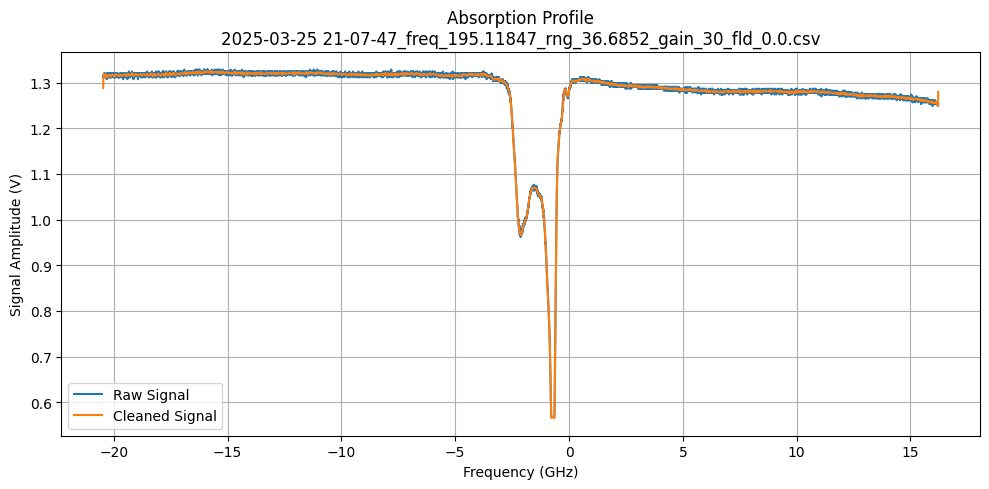


######## Multi-Lorentzian Fit Features ########
Dip 1:
  Center: -1.885634 GHz
  FWHM:   1339.35 MHz
  Depth:  -0.2319
#########################################

Dip 2:
  Center: -2.030768 GHz
  FWHM:   492.99 MHz
  Depth:  0.5061
#########################################

Dip 3:
  Center: -1.129595 GHz
  FWHM:   414.55 MHz
  Depth:  0.2803
#########################################

Dip 4:
  Center: -0.724020 GHz
  FWHM:   150.57 MHz
  Depth:  0.7208
#########################################



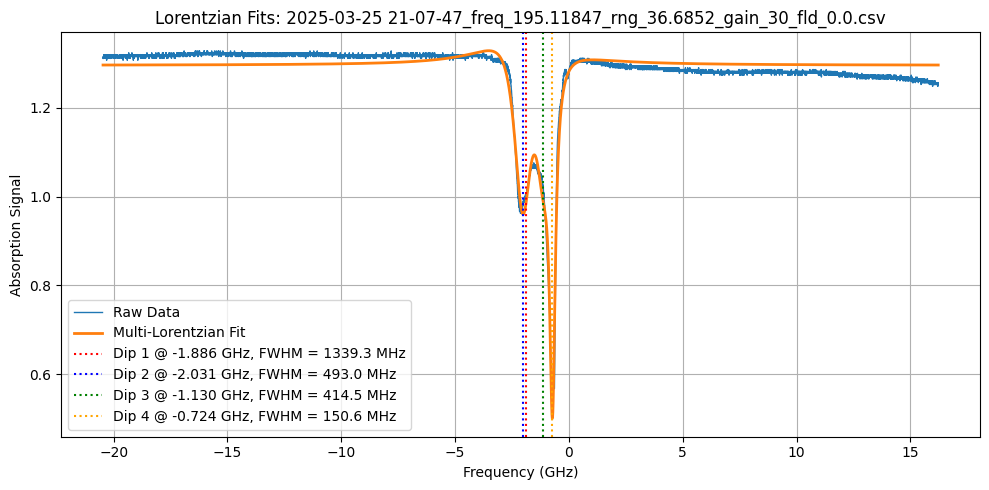


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 21-00-15_freq_195.11847_rng_36.6852_gain_30_fld_0.010616666666666667.csv


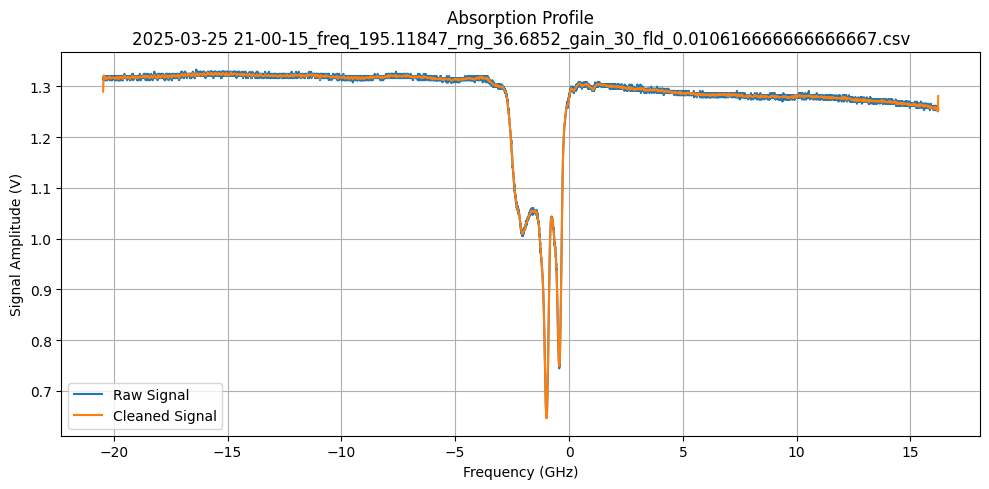


######## Multi-Lorentzian Fit Features ########
Dip 1:
  Center: -2.327905 GHz
  FWHM:   146.16 MHz
  Depth:  0.1488
#########################################

Dip 2:
  Center: -1.989045 GHz
  FWHM:   225.85 MHz
  Depth:  0.2253
#########################################

Dip 3:
  Center: -1.477876 GHz
  FWHM:   297.62 MHz
  Depth:  0.1694
#########################################

Dip 4:
  Center: -0.994524 GHz
  FWHM:   154.93 MHz
  Depth:  0.5623
#########################################

Dip 5:
  Center: -0.443163 GHz
  FWHM:   113.71 MHz
  Depth:  0.5156
#########################################



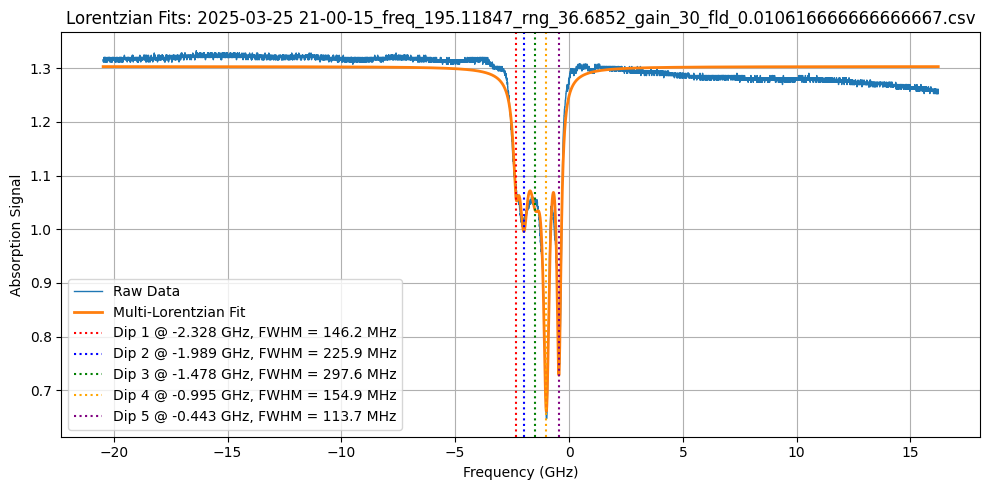


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-53-28_freq_195.11847_rng_36.6852_gain_30_fld_0.02002.csv


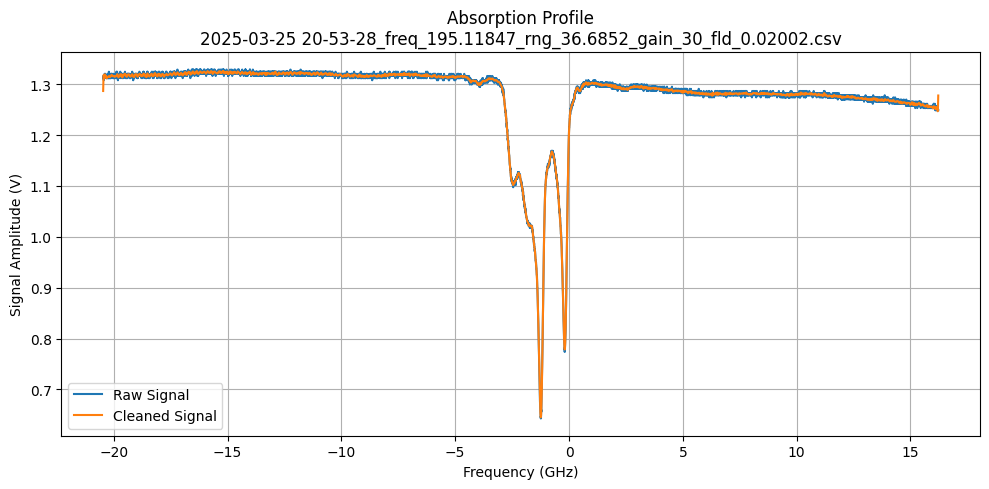


######## Multi-Lorentzian Fit Features ########
Dip 1:
  Center: -1.858594 GHz
  FWHM:   545.57 MHz
  Depth:  0.2471
#########################################

Dip 2:
  Center: -1.248199 GHz
  FWHM:   138.43 MHz
  Depth:  0.5357
#########################################

Dip 3:
  Center: -0.218126 GHz
  FWHM:   137.91 MHz
  Depth:  0.4852
#########################################



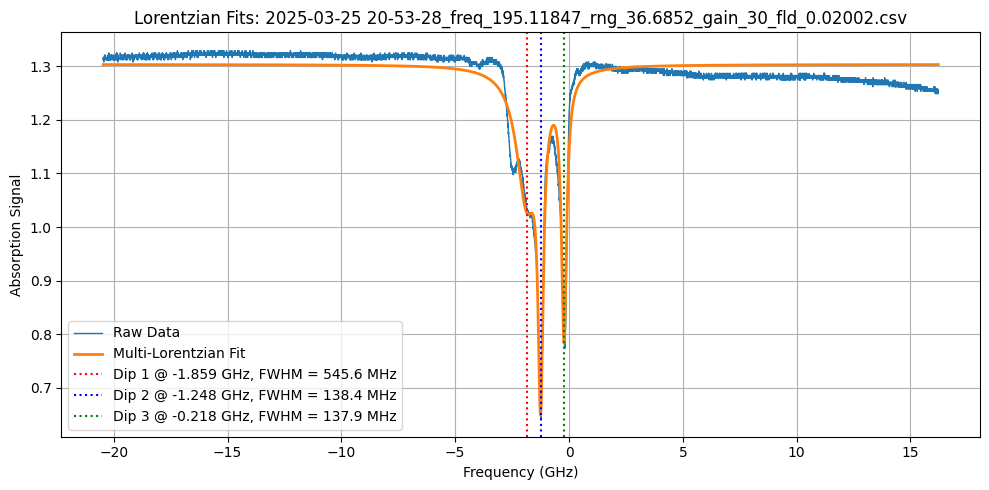


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-44-01_freq_195.11847_rng_36.6852_gain_30_fld_0.03306333333333333.csv


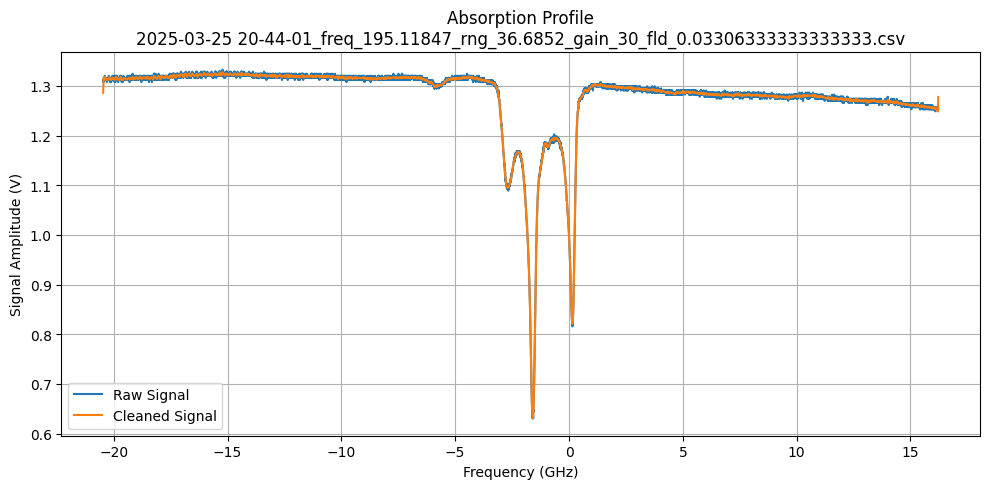


######## Multi-Lorentzian Fit Features ########
Dip 1:
  Center: -2.658065 GHz
  FWHM:   199.80 MHz
  Depth:  0.1958
#########################################

Dip 2:
  Center: -0.526984 GHz
  FWHM:   477.39 MHz
  Depth:  0.0931
#########################################

Dip 3:
  Center: -1.591122 GHz
  FWHM:   147.13 MHz
  Depth:  0.5987
#########################################

Dip 4:
  Center: -1.901395 GHz
  FWHM:   301.99 MHz
  Depth:  0.1070
#########################################

Dip 5:
  Center: 0.123179 GHz
  FWHM:   129.24 MHz
  Depth:  0.4534
#########################################



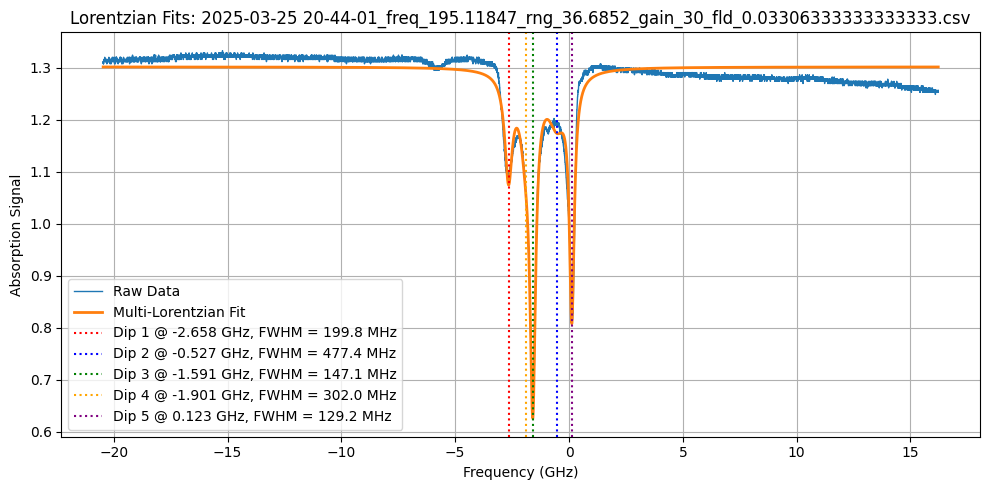


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-37-15_freq_195.11847_rng_36.6852_gain_30_fld_0.04216333333333334.csv


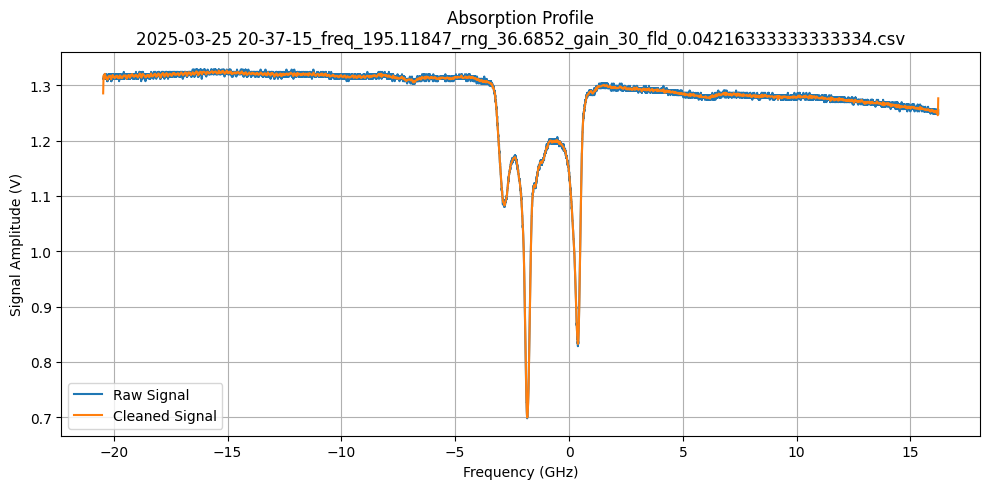


######## Multi-Lorentzian Fit Features ########
Dip 1:
  Center: -2.558701 GHz
  FWHM:   163.70 MHz
  Depth:  0.0706
#########################################

Dip 2:
  Center: -2.960683 GHz
  FWHM:   93.48 MHz
  Depth:  0.1215
#########################################

Dip 3:
  Center: -2.791612 GHz
  FWHM:   114.03 MHz
  Depth:  0.1419
#########################################

Dip 4:
  Center: -1.825345 GHz
  FWHM:   224.28 MHz
  Depth:  0.5253
#########################################

Dip 5:
  Center: 0.328114 GHz
  FWHM:   204.57 MHz
  Depth:  0.4261
#########################################



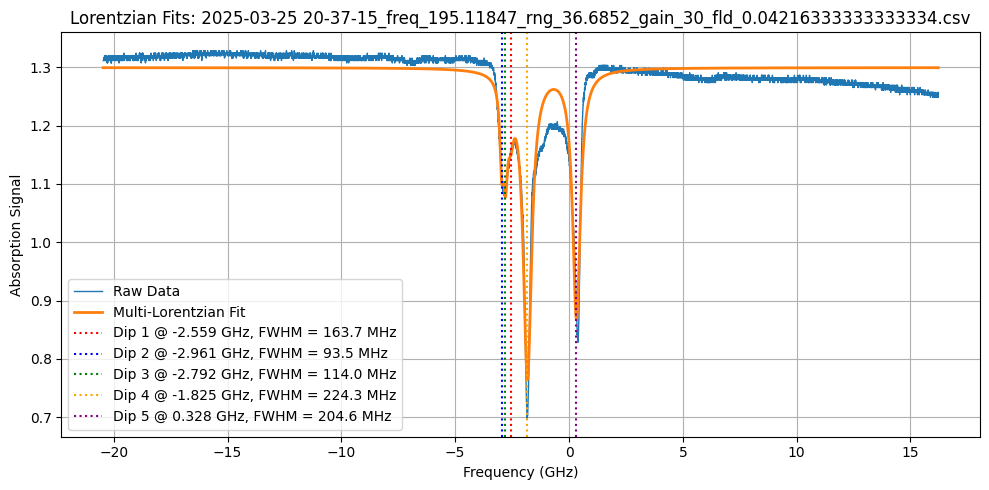


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-30-50_freq_195.11847_rng_36.6852_gain_30_fld_0.050960000000000005.csv


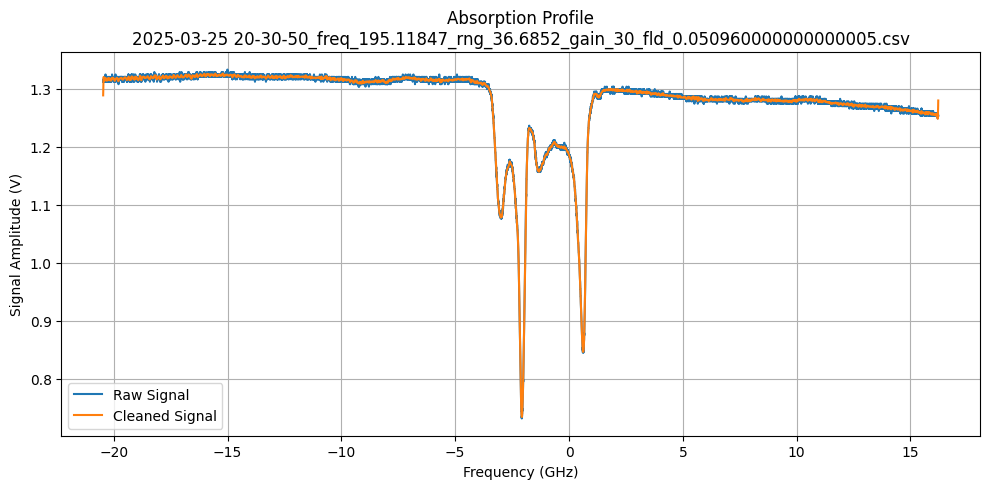

Fit failed


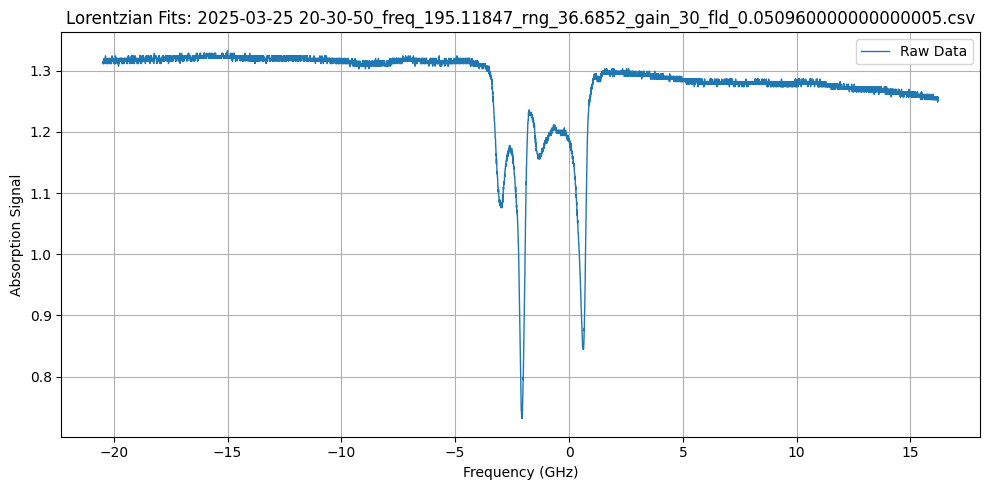


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-23-39_freq_195.11847_rng_36.6852_gain_30_fld_0.06097.csv


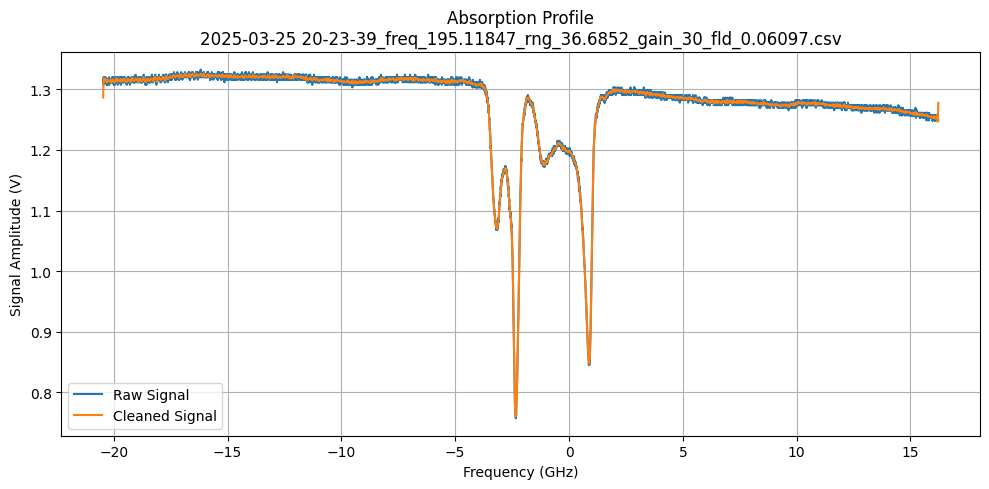


######## Multi-Lorentzian Fit Features ########
Dip 1:
  Center: -3.309270 GHz
  FWHM:   87.41 MHz
  Depth:  0.1311
#########################################

Dip 2:
  Center: -3.144043 GHz
  FWHM:   102.57 MHz
  Depth:  0.1723
#########################################

Dip 3:
  Center: -2.934823 GHz
  FWHM:   124.40 MHz
  Depth:  0.0757
#########################################

Dip 4:
  Center: -2.609887 GHz
  FWHM:   127.27 MHz
  Depth:  0.0878
#########################################

Dip 5:
  Center: -2.332125 GHz
  FWHM:   119.42 MHz
  Depth:  0.5351
#########################################

Dip 6:
  Center: -0.800245 GHz
  FWHM:   531.27 MHz
  Depth:  0.1114
#########################################

Dip 7:
  Center: 0.588719 GHz
  FWHM:   287.46 MHz
  Depth:  0.1660
#########################################

Dip 8:
  Center: 0.875228 GHz
  FWHM:   116.30 MHz
  Depth:  0.3885
#########################################



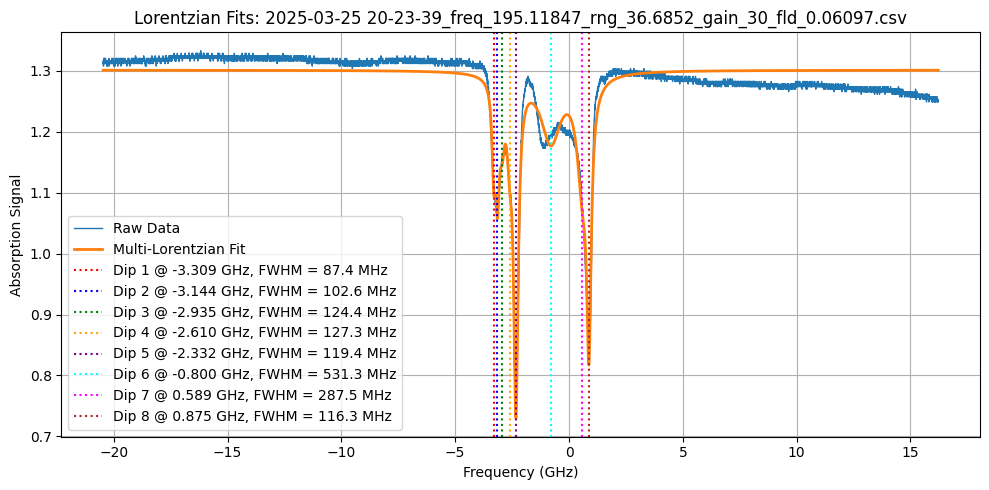


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-17-09_freq_195.11847_rng_36.6852_gain_30_fld_0.07007000000000001.csv


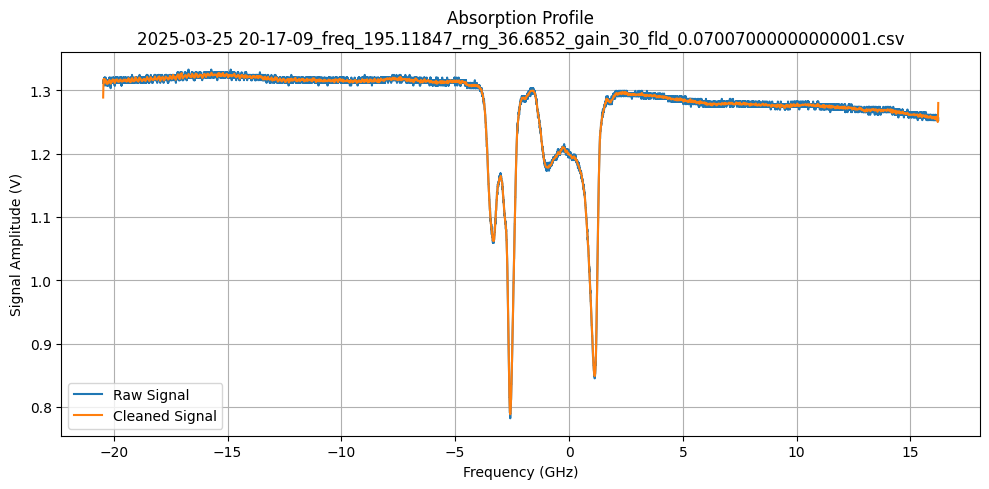

Fit failed


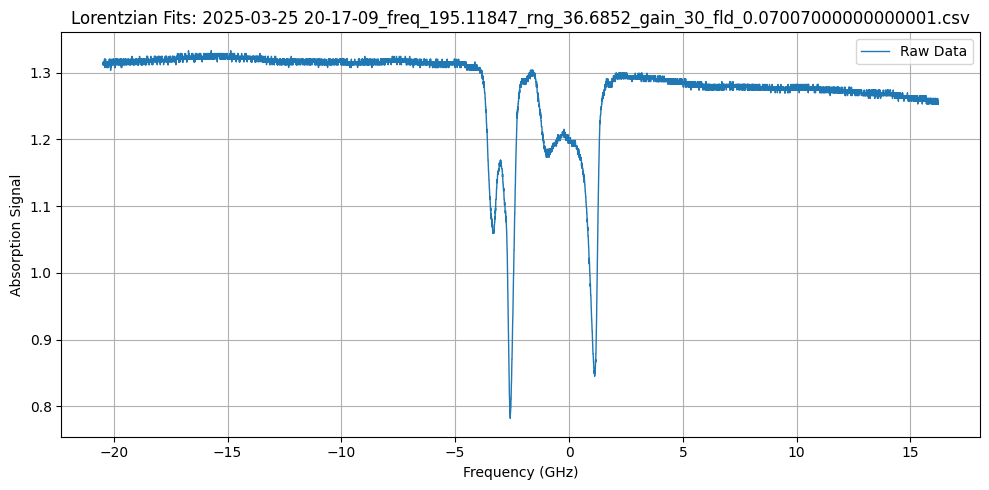


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-10-38_freq_195.11847_rng_36.6852_gain_30_fld_0.07886666666666667.csv


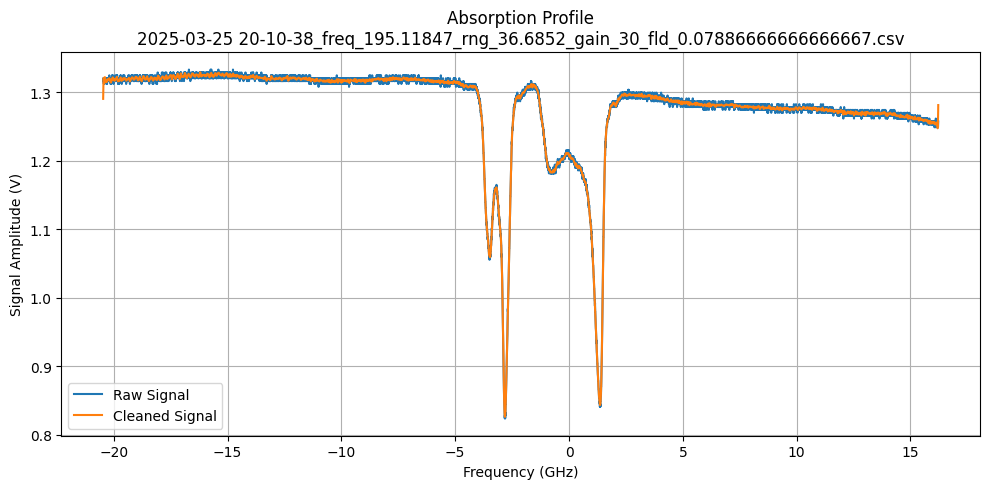

Fit failed


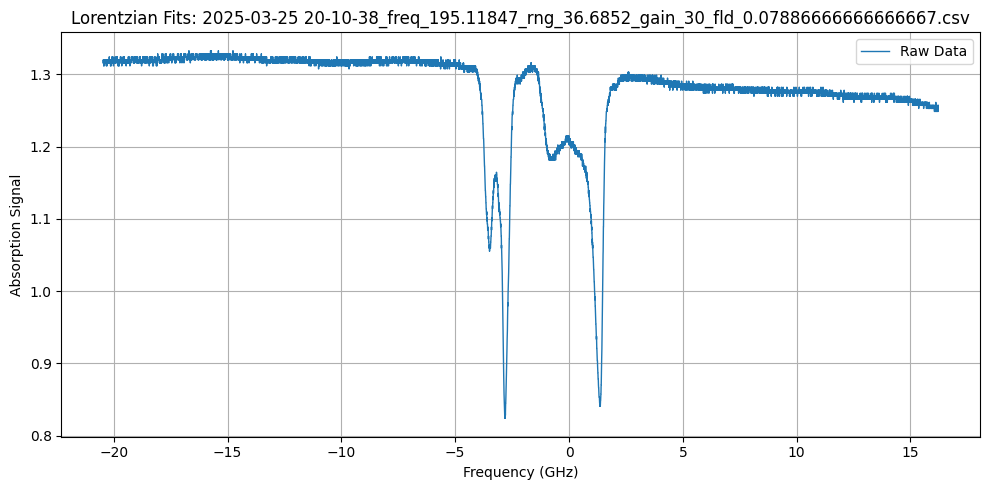


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-06-22_freq_195.11847_rng_36.6852_gain_30_fld_0.08463000000000001.csv


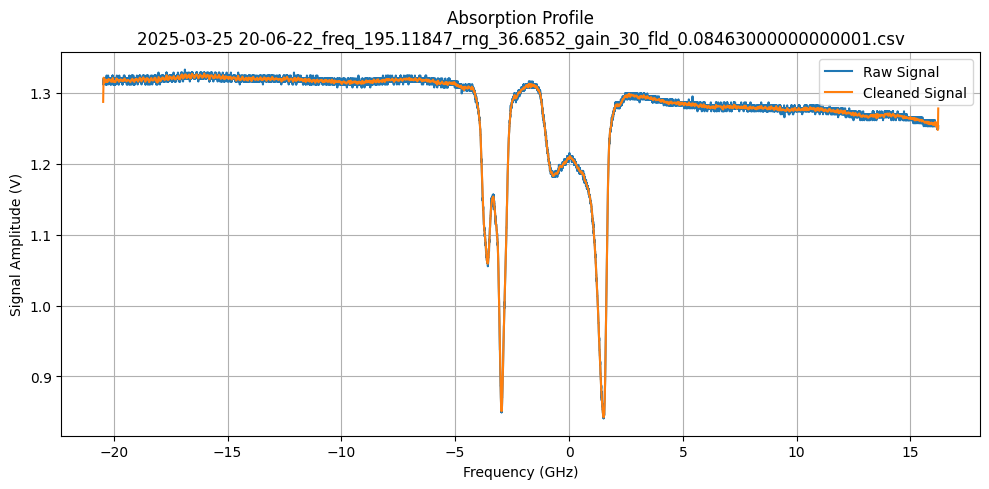


######## Multi-Lorentzian Fit Features ########
Dip 1:
  Center: -3.590011 GHz
  FWHM:   174.79 MHz
  Depth:  0.2330
#########################################

Dip 2:
  Center: -2.979576 GHz
  FWHM:   126.64 MHz
  Depth:  0.4103
#########################################

Dip 3:
  Center: -2.821049 GHz
  FWHM:   67.39 MHz
  Depth:  0.1220
#########################################

Dip 4:
  Center: 0.043279 GHz
  FWHM:   839.14 MHz
  Depth:  0.1106
#########################################

Dip 5:
  Center: 1.440204 GHz
  FWHM:   209.70 MHz
  Depth:  0.4415
#########################################



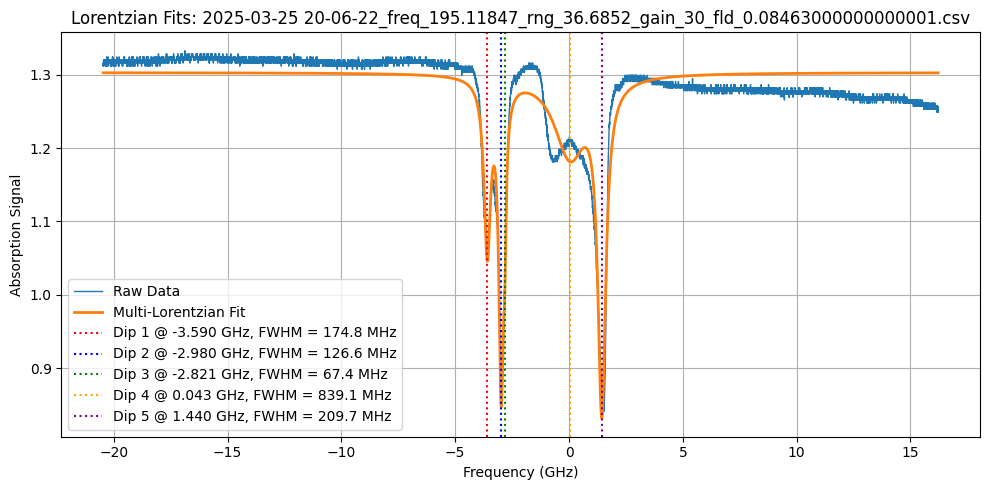


Processing file: data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-02-00_freq_195.11847_rng_36.6852_gain_30_fld_0.09069666666666668.csv


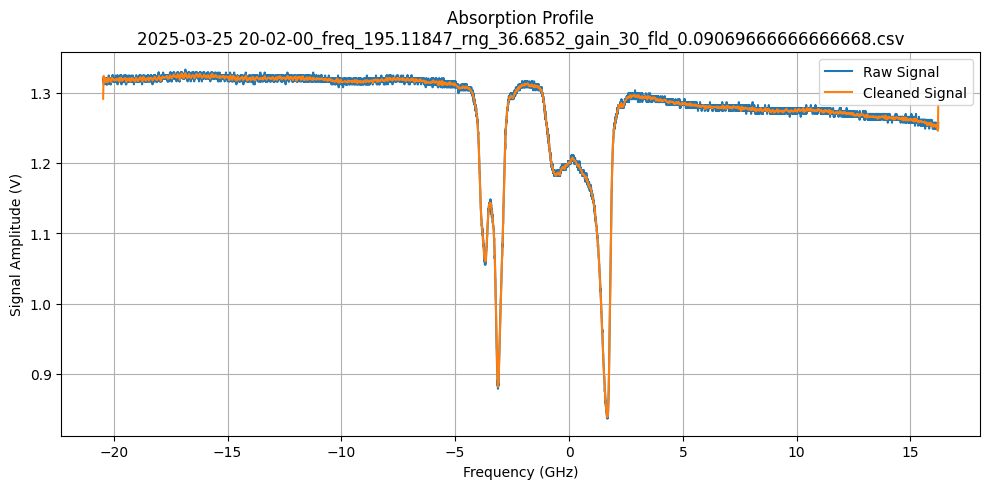

Fit failed


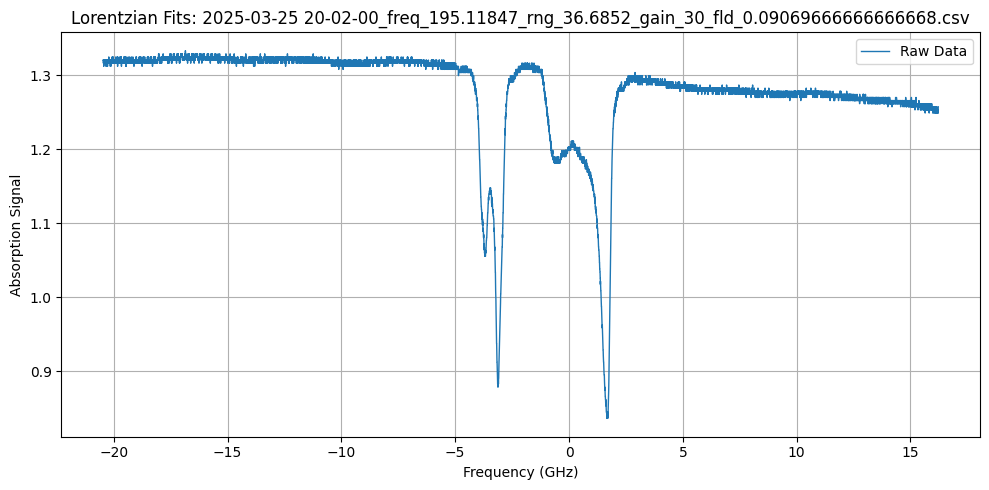

In [14]:

# List of data files
data_files = [
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 21-07-47_freq_195.11847_rng_36.6852_gain_30_fld_0.0.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 21-00-15_freq_195.11847_rng_36.6852_gain_30_fld_0.010616666666666667.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-53-28_freq_195.11847_rng_36.6852_gain_30_fld_0.02002.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-44-01_freq_195.11847_rng_36.6852_gain_30_fld_0.03306333333333333.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-37-15_freq_195.11847_rng_36.6852_gain_30_fld_0.04216333333333334.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-30-50_freq_195.11847_rng_36.6852_gain_30_fld_0.050960000000000005.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-23-39_freq_195.11847_rng_36.6852_gain_30_fld_0.06097.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-17-09_freq_195.11847_rng_36.6852_gain_30_fld_0.07007000000000001.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-10-38_freq_195.11847_rng_36.6852_gain_30_fld_0.07886666666666667.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-06-22_freq_195.11847_rng_36.6852_gain_30_fld_0.08463000000000001.csv",
    "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-02-00_freq_195.11847_rng_36.6852_gain_30_fld_0.09069666666666668.csv"
    # Add more files as needed
]

# Loop through each file
for data_file in data_files:
    print(f"\nProcessing file: {data_file}")
    
    # Step 1: read CSV
    data = pd.read_csv(data_file, header=None)

    # Extract time, signal, and frequency
    time_axis = data.iloc[0].values.astype(float)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)

    # Convert frequency from Hz to GHz for cleaner axis
    freq_axis_GHz = freq_axis / 1e9

    # Low-pass filter
    cleaned = mf.low_pass_band_filter_fft(20, freq_axis_GHz, voltage, plot_check=False)

    # Plot absorption profile
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(freq_axis_GHz, voltage, label='Raw Signal')
    ax.plot(freq_axis_GHz, cleaned, label='Cleaned Signal')
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("Signal Amplitude (V)")
    ax.set_title(f"Absorption Profile\n{data_file.split('/')[-1]}")
    ax.grid(True)
    ax.legend()
    fig.tight_layout()
    plt.show()

    # Perform multi-Lorentzian fit
    fit_result = mf.fit_multi_lorentzian_dip(
        freq_axis_GHz, voltage,
        window_width=0.08,
        min_prominence=0.05,
        max_lorentzians=20,
        to_print=True
    )
    #featfit_result = mf.fit_lorentzian_dip(freq_axis_GHz, voltage, window_width=0.1, min_prominence=0.01, to_print=False)
    # Plot fit results
    plt.figure(figsize=(10, 5))
    plt.plot(freq_axis_GHz, voltage, label='Raw Data', lw=1)

    if fit_result:
        plt.plot(freq_axis_GHz, fit_result["fit_curve"], label="Multi-Lorentzian Fit", lw=2)

        # Plot individual dips
        # for i, f in enumerate(fit_result["fits"]):
        #     plt.axvline(f["f_dip"], color='r', linestyle=':', label=f"Dip {i+1} @ {f['f_dip']:.3f} GHz, {f["FWHM"]*1000}")
        for i, f in enumerate(fit_result["fits"]):
            color = colors[i % len(colors)]  # wrap around if more dips than colors
            label = f"Dip {i+1} @ {f['f_dip']:.3f} GHz, FWHM = {f['FWHM']*1000:.1f} MHz"
            plt.axvline(f["f_dip"], color=color, linestyle=':', label=label)


    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Absorption Signal")
    plt.title(f"Lorentzian Fits: {data_file.split('/')[-1]}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

